In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_cv
import os

2024-06-08 23:01:36.952540: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 23:01:37.672971: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data Pipeline

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# dataset_location = './Food ingredient recognition.v4i.tfrecord'
# dataset_location = './drive/MyDrive/Food ingredient recognition.v4i.tfrecord' # Google Colab
dataset_location = "/mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/Food ingredient recognition.v4i.tfrecord" # Punya Andi
tfrecord_name = "food-ingredient.tfrecord"
print(os.path.exists(dataset_location))

True


In [4]:
dataset_train = tf.data.TFRecordDataset(dataset_location + f"/train/{tfrecord_name}")
dataset_validation = tf.data.TFRecordDataset(dataset_location + f"/valid/{tfrecord_name}")
dataset_test = tf.data.TFRecordDataset(dataset_location + f"/test/{tfrecord_name}")

2024-06-08 23:01:39.557219: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 23:01:39.641769: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 23:01:39.641830: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 23:01:39.645503: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 23:01:39.645559: I external/local_xla/xla/stream_executor

In [5]:
feature_description = {
    'image/object/bbox/ymin' : tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmin' : tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax' : tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax' : tf.io.VarLenFeature(tf.float32),
    'image/object/class/text' : tf.io.VarLenFeature(tf.string),
    'image/object/class/label' : tf.io.VarLenFeature(tf.int64),
    'image/encoded' : tf.io.FixedLenFeature([], tf.string),
    'image/format' : tf.io.FixedLenFeature([], tf.string),
    'image/filename' : tf.io.FixedLenFeature([], tf.string),
    'image/height' : tf.io.FixedLenFeature([], tf.int64),
    'image/width' : tf.io.FixedLenFeature([], tf.int64)
}
def _parse_function(example_proto):
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    bounding_box = ['image/object/bbox/ymin', 'image/object/bbox/xmin', 'image/object/bbox/ymax', 'image/object/bbox/xmax']
    for key in ['image/object/bbox/ymin', 'image/object/bbox/xmin', 'image/object/bbox/ymax', 'image/object/bbox/xmax', 'image/object/class/text', 'image/object/class/label']:
        parsed_example[key] = tf.sparse.to_dense(parsed_example[key])
        if (key in bounding_box and "x" in key):
            parsed_example[key] = parsed_example[key] * tf.cast(parsed_example['image/width'], tf.float32)
        elif (key in bounding_box):
            parsed_example[key] = parsed_example[key] * tf.cast(parsed_example['image/height'], tf.float32)
    return parsed_example

In [6]:
from keras_cv import bounding_box
from keras_cv import visualization

class_ids = [
    "-",
    "almond",
    "apple",
    "avocado",
    "beef",
    "bell pepper",
    "blueberry",
    "bread",
    "broccoli",
    "butter",
    "carrot",
    "cheese",
    "chilli",
    "cookie",
    "corn",
    "cucumber",
    "egg",
    "eggplant",
    "garlic",
    "lemon",
    "milk",
    "mozarella cheese",
    "mushroom",
    "mussel",
    "onion",
    "oyster",
    "parmesan cheese",
    "pasta",
    "pork rib",
    "potato",
    "salmon",
    "scallop",
    "shrimp",
    "strawberry",
    "toast bread",
    "tomato",
    "tuna",
    "yogurt",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

def preprocess_dataset(parsed_dataset):
    image = tf.image.decode_jpeg(parsed_dataset['image/encoded'])
    label = parsed_dataset['image/object/class/label']
    bounding_box = tf.stack([
        parsed_dataset['image/object/bbox/xmin'],
        parsed_dataset['image/object/bbox/ymin'],
        parsed_dataset['image/object/bbox/xmax'],
        parsed_dataset['image/object/bbox/ymax']
    ], axis=-1)
    image = tf.cast(image, tf.float32)
    return {
        'images': image,
        'bounding_boxes' : {
            'boxes': tf.cast(bounding_box, tf.float32),
            'classes': tf.cast(label, tf.int32)
        }
    }

def visualize_data(image, bounding_boxes):
    image = np.array(image)
    inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
    )
    image = inference_resizing([image])
    visualization.plot_bounding_box_gallery(
        image,
        value_range=(0, 255),
        rows=1,
        cols=1,
        scale=5,
        bounding_box_format='xywh',
        y_pred=bounding_boxes
    )

augmenter = tf.keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            # target_size=(416, 416), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
            target_size=(416, 416), scale_factor=(1, 1), bounding_box_format="xyxy"
        ),
    ]
)

validation_augmenter = tf.keras.Sequential(
    layers=[
        keras_cv.layers.JitteredResize(
            # target_size=(416, 416), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
            target_size=(416, 416), scale_factor=(1, 1), bounding_box_format="xyxy"
        )
    ]
)

2024-06-08 23:01:45.330650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


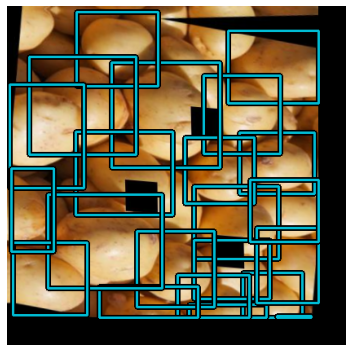

In [7]:
from keras_cv import bounding_box

BATCH_SIZE = 16

train_data_initial = dataset_train.map(_parse_function).map(preprocess_dataset).shuffle(buffer_size=BATCH_SIZE * 4).ragged_batch(BATCH_SIZE, drop_remainder=True)
train_data_resized = train_data_initial.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(inputs["bounding_boxes"], max_boxes=32)

train_data = train_data_resized.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

for result in train_data.take(1):
    visualization.plot_bounding_box_gallery(
        result[0],
        value_range=(0, 255),
        rows=1,
        cols=1,
        scale=5,
        bounding_box_format='xyxy',
        y_true=result[1]
    )


In [8]:
validation_data_initial = dataset_validation.map(_parse_function).map(preprocess_dataset).shuffle(buffer_size=BATCH_SIZE * 4).ragged_batch(BATCH_SIZE, drop_remainder=True)
validation_data_resized = validation_data_initial.map(validation_augmenter, num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data_resized.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

In [9]:
test_data_initial = dataset_test.map(_parse_function).map(preprocess_dataset).shuffle(buffer_size=BATCH_SIZE * 4).ragged_batch(BATCH_SIZE, drop_remainder=True)
test_data_resized = test_data_initial.map(validation_augmenter, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data_resized.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

In [10]:
# import keras

# pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
#     "yolo_v8_m_pascalvoc", bounding_box_format="xywh"
# )
# image = keras.utils.load_img("stock-photo-airport-with-many-airplanes-at-beautiful-sunset-324754607.jpg")
# image = np.array(image)
# # print(image.shape)

# visualization.plot_image_gallery(
#     np.array([image]),
#     value_range=(0, 255),
#     rows=1,
#     cols=1,
#     scale=5,)
# inference_resizing = keras_cv.layers.Resizing(
#     640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
# )
# image_batch = inference_resizing([image])
# # print(image_batch)
# class_ids = [
#     "Aeroplane",
#     "Bicycle",
#     "Bird",
#     "Boat",
#     "Bottle",
#     "Bus",
#     "Car",
#     "Cat",
#     "Chair",
#     "Cow",
#     "Dining Table",
#     "Dog",
#     "Horse",
#     "Motorbike",
#     "Person",
#     "Potted Plant",
#     "Sheep",
#     "Sofa",
#     "Train",
#     "Tvmonitor",
#     "Total",
# ]
# # class_mapping = dict(zip(range(len(class_ids)), class_ids))
# # y_pred = pretrained_model.predict(image_batch)

# # print(y_pred)

# for sample in train_data_unbatched.take(1):
#     image = np.array(sample['images'])
#     inference_resizing = keras_cv.layers.Resizing(
#     640, 640, pad_to_aspect_ratio=True, bounding_box_format="xyxy"
#     )
#     image = inference_resizing([image])
#     y_pred = pretrained_model.predict(image)
#     print(y_pred)
#     visualization.plot_bounding_box_gallery(
#         image,
#         value_range=(0, 255),
#         rows=1,
#         cols=1,
#         y_pred=y_pred,
#         scale=5,
#         font_scale=0.7,
#         bounding_box_format="xyxy",
#         class_mapping=class_mapping,
#     )


In [11]:
# Get the number of classes in the dataset
# unique_classes = set()
# for parsed_dataset in train_data:
#     classes = parsed_dataset['bounding_boxes']['classes'].numpy()
#     unique_classes.update(np.unique(classes))

# NUM_CLASSES = len(unique_classes)
NUM_CLASSES = len(class_ids)

In [12]:
# Pretrained backbone
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco",
    include_rescaling = True,
)

prediction_decoder = keras_cv.layers.NonMaxSuppression(
    from_logits=True,
    # Makin tinggi perlu confidence makin tinggi
    confidence_threshold=0.731,
    # Makin rendah maka makin sedikit bounding box yang diambil
    iou_threshold=0.2,
    bounding_box_format="xyxy",
)

# model = keras_cv.models.YOLOV8Detector(
#     num_classes=NUM_CLASSES,
#     bounding_box_format="xyxy",
#     backbone=backbone,
#     fpn_depth=1,
#     prediction_decoder=prediction_decoder,
# )


model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_s_backbone_coco", 
    bounding_box_format="xyxy",
    num_classes=NUM_CLASSES,
    prediction_decoder=prediction_decoder,
)



In [13]:
freeze = 133
# Freeze to up to 133 layers
# for i, layer in enumerate(model.layers):
#     if i < freeze:
#         layer.trainable = False


In [14]:
class EvaluateCOCOMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

In [16]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    global_clipnorm = 10.0
)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

model.compile(
    optimizer=optimizer, 
    # classification_loss="binary_crossentropy", 
    classification_loss=tf.keras.losses.CategoricalCrossentropy(),
    box_loss=keras_cv.losses.CIoULoss("xyxy", eps=1e-07)
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

model.fit(train_data, 
          epochs=350, 
          validation_data=validation_data,
          callbacks=[EvaluateCOCOMetricsCallback(validation_data, "model.keras")])

Epoch 1/350


I0000 00:00:1717862574.954133  315710 service.cc:145] XLA service 0x7f0c30003970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717862574.954241  315710 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-06-08 23:02:58.215466: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-08 23:03:00.254133: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1717862617.829560  315710 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_negate_slice_fusion_1', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1717862617.885941  315710 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    183/Unknown 91s 144ms/step - loss: 1.0409e-04

2024-06-08 23:04:04.440876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:04:04.441870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-06-08 23:04:10.615059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:04:10.615140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is abortin

183/183 ━━━━━━━━━━━━━━━━━━━━ 106s 227ms/step - loss: 1.0408e-04 - val_loss: 1.0954e-04 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 2/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 9.6594e-05

2024-06-08 23:04:50.539703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:04:50.541056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:04:52.718361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:04:52.718603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:04:55.958436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 9.6587e-05 - val_loss: 9.8543e-05 - MaP: 8.1061e-06 - MaP@[IoU=50]: 8.1061e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.0839e-05 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 7.4074e-04 - Recall@[max_detections=100]: 7.4074e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0010
Epoch 3/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 9.2293e-05

2024-06-08 23:05:29.606401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:05:29.607386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:05:31.577269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:05:31.577465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - loss: 9.2289e-05 - val_loss: 9.6044e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 4/350


2024-06-08 23:05:34.461205: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 9.0556e-05

2024-06-08 23:06:05.582529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:06:05.582976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:06:07.557224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:06:07.557291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:06:10.395720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 191ms/step - loss: 9.0554e-05 - val_loss: 9.1631e-05 - MaP: 1.7472e-04 - MaP@[IoU=50]: 5.8241e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.5990e-04 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 8.4034e-04 - Recall@[max_detections=100]: 8.4034e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0012
Epoch 5/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 8.8230e-05

2024-06-08 23:06:44.547643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:06:44.548688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:06:46.563939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:06:46.564045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 8.8234e-05 - val_loss: 9.1154e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 6/350


2024-06-08 23:06:49.557089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 8.8726e-05

2024-06-08 23:07:20.999110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:07:21.000083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:07:23.044314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:07:23.044423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:07:25.902760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 8.8725e-05 - val_loss: 9.1848e-05 - MaP: 0.0049 - MaP@[IoU=50]: 0.0103 - MaP@[IoU=75]: 0.0035 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0060 - Recall@[max_detections=1]: 0.0157 - Recall@[max_detections=10]: 0.0165 - Recall@[max_detections=100]: 0.0165 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0203
Epoch 7/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 8.6311e-05

2024-06-08 23:07:59.122975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:07:59.123832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:08:01.249466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:08:01.249606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - loss: 8.6315e-05 - val_loss: 9.3359e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 8/350


2024-06-08 23:08:04.265823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 8.5772e-05

2024-06-08 23:08:36.308158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:08:36.309188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:08:38.293377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:08:38.293447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:08:41.133474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - loss: 8.5778e-05 - val_loss: 9.1381e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 9/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 8.4957e-05

2024-06-08 23:09:12.876265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:09:12.877192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:09:14.997123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:09:14.997212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:09:17.917811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - loss: 8.4957e-05 - val_loss: 9.1151e-05 - MaP: 0.0032 - MaP@[IoU=50]: 0.0049 - MaP@[IoU=75]: 0.0032 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0042 - Recall@[max_detections=1]: 0.0073 - Recall@[max_detections=10]: 0.0073 - Recall@[max_detections=100]: 0.0073 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0097
Epoch 10/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 8.6824e-05

2024-06-08 23:09:49.933531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:09:49.934488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:09:51.915172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:09:51.915389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:09:54.910927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - loss: 8.6816e-05 - val_loss: 8.9735e-05 - MaP: 1.0477e-05 - MaP@[IoU=50]: 1.0477e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.6502e-05 - Recall@[max_detections=1]: 1.0582e-04 - Recall@[max_detections=10]: 2.1164e-04 - Recall@[max_detections=100]: 2.1164e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 3.4483e-04
Epoch 11/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 8.3679e-05

2024-06-08 23:10:27.409329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:10:27.410395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:10:29.339982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:10:29.340046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:10:32.239788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 187ms/step - loss: 8.3683e-05 - val_loss: 8.9995e-05 - MaP: 0.0030 - MaP@[IoU=50]: 0.0067 - MaP@[IoU=75]: 0.0022 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0032 - Recall@[max_detections=1]: 0.0060 - Recall@[max_detections=10]: 0.0060 - Recall@[max_detections=100]: 0.0060 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0064
Epoch 12/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 8.4964e-05

2024-06-08 23:11:04.938604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:11:04.939531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:11:06.832164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:11:06.832368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:11:09.849528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 8.4964e-05 - val_loss: 9.0443e-05 - MaP: 7.1146e-04 - MaP@[IoU=50]: 0.0014 - MaP@[IoU=75]: 5.6577e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 8.3746e-04 - Recall@[max_detections=1]: 0.0017 - Recall@[max_detections=10]: 0.0017 - Recall@[max_detections=100]: 0.0017 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0026
Epoch 13/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 8.4290e-05

2024-06-08 23:11:42.234668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:11:42.235663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:11:44.320474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:11:44.320544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:11:47.252720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 186ms/step - loss: 8.4286e-05 - val_loss: 9.0257e-05 - MaP: 1.9414e-05 - MaP@[IoU=50]: 9.7069e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.0627e-05 - Recall@[max_detections=1]: 1.2788e-04 - Recall@[max_detections=10]: 1.2788e-04 - Recall@[max_detections=100]: 1.2788e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 1.7361e-04
Epoch 14/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 8.4330e-05

2024-06-08 23:12:20.070337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:12:20.071423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:12:22.275622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:12:22.275873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:12:25.210778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 196ms/step - loss: 8.4332e-05 - val_loss: 9.2406e-05 - MaP: 9.5384e-04 - MaP@[IoU=50]: 0.0018 - MaP@[IoU=75]: 7.4579e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0011 - Recall@[max_detections=1]: 0.0023 - Recall@[max_detections=10]: 0.0023 - Recall@[max_detections=100]: 0.0023 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0025
Epoch 15/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 8.3343e-05

2024-06-08 23:12:57.464255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:12:57.465271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:12:59.441889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:12:59.442193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:13:02.408036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - loss: 8.3342e-05 - val_loss: 9.2056e-05 - MaP: 3.9970e-04 - MaP@[IoU=50]: 0.0012 - MaP@[IoU=75]: 3.3542e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 4.5815e-04 - Recall@[max_detections=1]: 0.0018 - Recall@[max_detections=10]: 0.0018 - Recall@[max_detections=100]: 0.0018 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0021
Epoch 16/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 8.3262e-05

2024-06-08 23:13:35.346318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:13:35.347213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:13:37.331371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:13:37.331585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:13:40.279998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 8.3265e-05 - val_loss: 8.4169e-05 - MaP: 1.5980e-04 - MaP@[IoU=50]: 5.1637e-04 - MaP@[IoU=75]: 2.5322e-05 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.9093e-04 - Recall@[max_detections=1]: 0.0012 - Recall@[max_detections=10]: 0.0012 - Recall@[max_detections=100]: 0.0012 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0014
Epoch 17/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 8.1222e-05

2024-06-08 23:14:13.022434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:14:13.023298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:14:15.001171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:14:15.001231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:14:17.872656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 189ms/step - loss: 8.1222e-05 - val_loss: 8.9074e-05 - MaP: 4.0919e-05 - MaP@[IoU=50]: 2.2896e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 4.4947e-05 - Recall@[max_detections=1]: 3.6769e-04 - Recall@[max_detections=10]: 6.0924e-04 - Recall@[max_detections=100]: 6.0924e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 9.0729e-04
Epoch 18/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 8.2170e-05

2024-06-08 23:14:50.463626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:14:50.464332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:14:52.396227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:14:52.396295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:14:55.445951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 191ms/step - loss: 8.2169e-05 - val_loss: 9.1118e-05 - MaP: 0.0037 - MaP@[IoU=50]: 0.0060 - MaP@[IoU=75]: 0.0041 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0044 - Recall@[max_detections=1]: 0.0094 - Recall@[max_detections=10]: 0.0099 - Recall@[max_detections=100]: 0.0099 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0120
Epoch 19/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 8.5058e-05

2024-06-08 23:15:28.041973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:15:28.042550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:15:30.087609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:15:30.087672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-08 23:15:30.087706: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 674719814815746160
2024-06-08 23:15:32.992134: W tensorflow/core/framework/local_rend

183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 8.5050e-05 - val_loss: 9.2549e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 20/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 8.2273e-05

2024-06-08 23:16:05.264650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:16:05.265091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:16:07.437678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:16:07.437774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:16:10.414984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 8.2272e-05 - val_loss: 9.5494e-05 - MaP: 0.0010 - MaP@[IoU=50]: 0.0021 - MaP@[IoU=75]: 6.3623e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0011 - Recall@[max_detections=1]: 0.0026 - Recall@[max_detections=10]: 0.0026 - Recall@[max_detections=100]: 0.0026 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0029
Epoch 21/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 8.2889e-05

2024-06-08 23:16:43.123664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:16:43.124930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:16:45.277817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:16:45.277915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:16:48.332784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 8.2883e-05 - val_loss: 8.4971e-05 - MaP: 2.2538e-04 - MaP@[IoU=50]: 8.2428e-04 - MaP@[IoU=75]: 9.0462e-05 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.6398e-04 - Recall@[max_detections=1]: 0.0014 - Recall@[max_detections=10]: 0.0020 - Recall@[max_detections=100]: 0.0020 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0023
Epoch 22/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 8.2173e-05

2024-06-08 23:17:21.852510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:17:21.853563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:17:23.829851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:17:23.829918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:17:26.853433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 197ms/step - loss: 8.2171e-05 - val_loss: 9.2476e-05 - MaP: 2.1485e-06 - MaP@[IoU=50]: 1.0742e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.3499e-06 - Recall@[max_detections=1]: 1.1662e-04 - Recall@[max_detections=10]: 1.1662e-04 - Recall@[max_detections=100]: 1.1662e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 1.2755e-04
Epoch 23/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 8.4189e-05

2024-06-08 23:17:59.797653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:17:59.798663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:18:01.721537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:18:01.721598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:18:01.721611: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 674719814815746160
2024-06-08 23:18:01.721617: I tensorflow/core/framework/local_rend

183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 188ms/step - loss: 8.4185e-05 - val_loss: 9.2823e-05 - MaP: 2.8566e-06 - MaP@[IoU=50]: 1.6294e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 4.8992e-06 - Recall@[max_detections=1]: 5.9524e-05 - Recall@[max_detections=10]: 2.7778e-04 - Recall@[max_detections=100]: 2.7778e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 4.3290e-04
Epoch 24/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 8.1836e-05

2024-06-08 23:18:37.847069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:18:37.848483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:18:40.016608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:18:40.016708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:18:42.998765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 8.1837e-05 - val_loss: 8.6366e-05 - MaP: 1.8935e-04 - MaP@[IoU=50]: 5.6461e-04 - MaP@[IoU=75]: 1.7408e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.6546e-04 - Recall@[max_detections=1]: 0.0011 - Recall@[max_detections=10]: 0.0011 - Recall@[max_detections=100]: 0.0011 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0017
Epoch 25/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 7.9026e-05

2024-06-08 23:19:16.066047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:19:16.067237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:19:18.174288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:19:18.174360: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 674719814815746160
2024-06-08 23:19:18.174384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-08 23:19:21.208502: W tensorflow/core/framework/local_rend

183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 7.9031e-05 - val_loss: 9.0751e-05 - MaP: 1.0404e-04 - MaP@[IoU=50]: 1.8443e-04 - MaP@[IoU=75]: 1.6973e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.1191e-04 - Recall@[max_detections=1]: 3.5714e-04 - Recall@[max_detections=10]: 5.1925e-04 - Recall@[max_detections=100]: 5.1925e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 7.1805e-04
Epoch 26/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 8.2960e-05

2024-06-08 23:19:53.710248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:19:53.711288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:19:55.736988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:19:55.737137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:19:58.782558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 8.2957e-05 - val_loss: 8.6378e-05 - MaP: 1.0652e-04 - MaP@[IoU=50]: 9.4160e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.1794e-04 - Recall@[max_detections=1]: 4.6083e-04 - Recall@[max_detections=10]: 6.4516e-04 - Recall@[max_detections=100]: 6.4516e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 7.3529e-04
Epoch 27/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 8.0525e-05

2024-06-08 23:20:31.656920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:20:31.658031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:20:33.729930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:20:33.729987: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 674719814815746160
2024-06-08 23:20:33.730009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-08 23:20:36.801348: W tensorflow/core/framework/local_rend

183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 199ms/step - loss: 8.0525e-05 - val_loss: 9.0850e-05 - MaP: 3.4998e-04 - MaP@[IoU=50]: 5.4138e-04 - MaP@[IoU=75]: 3.9757e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.9572e-04 - Recall@[max_detections=1]: 0.0030 - Recall@[max_detections=10]: 0.0031 - Recall@[max_detections=100]: 0.0031 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0035
Epoch 28/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 8.1957e-05

2024-06-08 23:21:09.944064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:21:09.945068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:21:12.051110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:21:12.051274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:21:15.028969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 8.1949e-05 - val_loss: 8.8095e-05 - MaP: 0.0031 - MaP@[IoU=50]: 0.0072 - MaP@[IoU=75]: 0.0017 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0033 - Recall@[max_detections=1]: 0.0104 - Recall@[max_detections=10]: 0.0105 - Recall@[max_detections=100]: 0.0105 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0117
Epoch 29/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 8.1113e-05

2024-06-08 23:21:47.545410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:21:47.546035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:21:49.612195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:21:49.612471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:21:52.611523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 8.1112e-05 - val_loss: 8.1297e-05 - MaP: 0.0012 - MaP@[IoU=50]: 0.0032 - MaP@[IoU=75]: 8.3942e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0012 - Recall@[max_detections=1]: 0.0088 - Recall@[max_detections=10]: 0.0089 - Recall@[max_detections=100]: 0.0089 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0095
Epoch 30/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 7.9592e-05

2024-06-08 23:22:25.533688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:22:25.535235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:22:27.613159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:22:27.613362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:22:30.621646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 197ms/step - loss: 7.9590e-05 - val_loss: 8.5063e-05 - MaP: 3.5490e-05 - MaP@[IoU=50]: 1.9697e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 7.0015e-05 - Recall@[max_detections=1]: 4.1710e-05 - Recall@[max_detections=10]: 2.9197e-04 - Recall@[max_detections=100]: 2.9197e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 4.3736e-04
Epoch 31/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 8.1244e-05

2024-06-08 23:23:03.492555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:23:03.493612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:23:05.576680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:23:05.576919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:23:08.628406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - loss: 8.1240e-05 - val_loss: 8.8214e-05 - MaP: 1.9076e-04 - MaP@[IoU=50]: 4.4861e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.0932e-04 - Recall@[max_detections=1]: 4.8632e-04 - Recall@[max_detections=10]: 6.6489e-04 - Recall@[max_detections=100]: 6.6489e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 8.9717e-04
Epoch 32/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 8.0709e-05

2024-06-08 23:23:41.457590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:23:41.458938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:23:43.476367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:23:43.476513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:23:46.501529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 8.0709e-05 - val_loss: 9.1232e-05 - MaP: 3.0799e-04 - MaP@[IoU=50]: 0.0010 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.7823e-04 - Recall@[max_detections=1]: 8.1047e-04 - Recall@[max_detections=10]: 0.0013 - Recall@[max_detections=100]: 0.0013 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0019
Epoch 33/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 8.0583e-05

2024-06-08 23:24:20.730182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:24:20.730733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:24:22.781821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:24:22.782204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:24:25.859097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 194ms/step - loss: 8.0581e-05 - val_loss: 8.4072e-05 - MaP: 2.9645e-04 - MaP@[IoU=50]: 0.0013 - MaP@[IoU=75]: 1.7355e-06 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.8681e-04 - Recall@[max_detections=1]: 9.8651e-04 - Recall@[max_detections=10]: 0.0019 - Recall@[max_detections=100]: 0.0019 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0025
Epoch 34/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 7.7531e-05

2024-06-08 23:24:58.767772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:24:58.768769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:25:00.782215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:25:00.782473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:25:03.811463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 7.7535e-05 - val_loss: 8.4658e-05 - MaP: 0.0011 - MaP@[IoU=50]: 0.0033 - MaP@[IoU=75]: 8.1008e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0013 - Recall@[max_detections=1]: 0.0035 - Recall@[max_detections=10]: 0.0035 - Recall@[max_detections=100]: 0.0035 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0039
Epoch 35/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 7.8024e-05

2024-06-08 23:25:36.745292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:25:36.746349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:25:38.798274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:25:38.798420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:25:41.872261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 7.8029e-05 - val_loss: 8.5551e-05 - MaP: 5.6719e-05 - MaP@[IoU=50]: 2.8431e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 9.0312e-05 - Recall@[max_detections=1]: 1.0390e-04 - Recall@[max_detections=10]: 1.2374e-04 - Recall@[max_detections=100]: 1.2374e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 1.5488e-04
Epoch 36/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 8.0520e-05

2024-06-08 23:26:14.747900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:26:14.748756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:26:16.923852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:26:16.923920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:26:19.908868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - loss: 8.0514e-05 - val_loss: 9.0848e-05 - MaP: 7.7756e-04 - MaP@[IoU=50]: 0.0024 - MaP@[IoU=75]: 1.4889e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 8.5120e-04 - Recall@[max_detections=1]: 0.0032 - Recall@[max_detections=10]: 0.0061 - Recall@[max_detections=100]: 0.0061 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0067
Epoch 37/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 7.9558e-05

2024-06-08 23:26:53.090751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:26:53.091688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:26:55.158518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:26:55.158659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:26:58.423753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 7.9558e-05 - val_loss: 8.7610e-05 - MaP: 3.6362e-04 - MaP@[IoU=50]: 0.0020 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 4.2000e-04 - Recall@[max_detections=1]: 0.0013 - Recall@[max_detections=10]: 0.0013 - Recall@[max_detections=100]: 0.0013 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0016
Epoch 38/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 8.0304e-05

2024-06-08 23:27:31.683685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:27:31.684664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:27:33.784071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:27:33.784145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:27:36.845835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 196ms/step - loss: 8.0298e-05 - val_loss: 8.4828e-05 - MaP: 6.9359e-04 - MaP@[IoU=50]: 0.0012 - MaP@[IoU=75]: 0.0010 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 7.6247e-04 - Recall@[max_detections=1]: 0.0028 - Recall@[max_detections=10]: 0.0033 - Recall@[max_detections=100]: 0.0033 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0042
Epoch 39/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 8.0409e-05

2024-06-08 23:28:09.330971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:28:09.331456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:28:11.448061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:28:11.448227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:28:14.503127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 8.0410e-05 - val_loss: 8.8566e-05 - MaP: 1.6239e-04 - MaP@[IoU=50]: 7.5428e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.1539e-04 - Recall@[max_detections=1]: 0.0010 - Recall@[max_detections=10]: 0.0019 - Recall@[max_detections=100]: 0.0019 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0024
Epoch 40/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 7.9809e-05

2024-06-08 23:28:48.253707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:28:48.254773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:28:50.388826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:28:50.389073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:28:53.523653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 199ms/step - loss: 7.9803e-05 - val_loss: 8.1600e-05 - MaP: 7.1806e-04 - MaP@[IoU=50]: 0.0015 - MaP@[IoU=75]: 6.7893e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 7.6158e-04 - Recall@[max_detections=1]: 0.0013 - Recall@[max_detections=10]: 0.0027 - Recall@[max_detections=100]: 0.0027 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0029
Epoch 41/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 7.7929e-05

2024-06-08 23:29:26.163858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:29:26.164889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:29:28.183028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:29:28.183163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:29:31.187431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 7.7934e-05 - val_loss: 8.6106e-05 - MaP: 5.8657e-04 - MaP@[IoU=50]: 0.0016 - MaP@[IoU=75]: 6.0425e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 7.1170e-04 - Recall@[max_detections=1]: 0.0031 - Recall@[max_detections=10]: 0.0031 - Recall@[max_detections=100]: 0.0031 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0037
Epoch 42/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 7.7016e-05

2024-06-08 23:30:04.411477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:30:04.412448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:30:06.453100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:30:06.453202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:30:09.599851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 7.7022e-05 - val_loss: 8.6342e-05 - MaP: 2.3587e-06 - MaP@[IoU=50]: 1.5586e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 4.3052e-06 - Recall@[max_detections=1]: 1.0018e-04 - Recall@[max_detections=10]: 1.0018e-04 - Recall@[max_detections=100]: 1.0018e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 1.8174e-04
Epoch 43/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 7.8946e-05

2024-06-08 23:30:42.432237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:30:42.433185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:30:44.683325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:30:44.683389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:30:47.756158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 7.8945e-05 - val_loss: 8.3513e-05 - MaP: 7.7655e-05 - MaP@[IoU=50]: 7.7655e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.2966e-04 - Recall@[max_detections=1]: 2.2624e-04 - Recall@[max_detections=10]: 2.2624e-04 - Recall@[max_detections=100]: 2.2624e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 3.5714e-04
Epoch 44/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 7.9411e-05

2024-06-08 23:31:20.514867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:31:20.516025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:31:22.565239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:31:22.565352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:31:25.588215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 7.9405e-05 - val_loss: 8.4793e-05 - MaP: 8.2825e-04 - MaP@[IoU=50]: 0.0029 - MaP@[IoU=75]: 1.8200e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 9.5078e-04 - Recall@[max_detections=1]: 0.0071 - Recall@[max_detections=10]: 0.0071 - Recall@[max_detections=100]: 0.0071 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0075
Epoch 45/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 7.8643e-05

2024-06-08 23:31:58.139001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:31:58.139419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:32:00.203344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:32:00.203545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:32:03.272961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 7.8647e-05 - val_loss: 8.1999e-05 - MaP: 2.1898e-04 - MaP@[IoU=50]: 8.5471e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.4424e-04 - Recall@[max_detections=1]: 0.0021 - Recall@[max_detections=10]: 0.0021 - Recall@[max_detections=100]: 0.0021 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0024
Epoch 46/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 7.5624e-05

2024-06-08 23:32:36.880958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:32:36.881413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:32:38.887018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:32:38.887091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:32:42.013785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 196ms/step - loss: 7.5626e-05 - val_loss: 9.2117e-05 - MaP: 0.0011 - MaP@[IoU=50]: 0.0039 - MaP@[IoU=75]: 5.1049e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0014 - Recall@[max_detections=1]: 0.0046 - Recall@[max_detections=10]: 0.0046 - Recall@[max_detections=100]: 0.0046 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0055
Epoch 47/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 7.7261e-05

2024-06-08 23:33:14.465609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:33:14.466056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:33:16.477981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:33:16.478099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:33:19.433722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 7.7260e-05 - val_loss: 8.9274e-05 - MaP: 8.2809e-04 - MaP@[IoU=50]: 0.0026 - MaP@[IoU=75]: 5.5546e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 9.5348e-04 - Recall@[max_detections=1]: 0.0055 - Recall@[max_detections=10]: 0.0055 - Recall@[max_detections=100]: 0.0055 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0059
Epoch 48/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 7.8702e-05

2024-06-08 23:33:52.428332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:33:52.429460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:33:54.374266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:33:54.374318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:33:57.395259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 7.8697e-05 - val_loss: 8.5688e-05 - MaP: 7.9948e-04 - MaP@[IoU=50]: 0.0029 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 8.2705e-04 - Recall@[max_detections=1]: 0.0030 - Recall@[max_detections=10]: 0.0030 - Recall@[max_detections=100]: 0.0030 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0031
Epoch 49/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 7.5703e-05

2024-06-08 23:34:30.108227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:34:30.109188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:34:32.156536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:34:32.156704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:34:35.168916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 7.5711e-05 - val_loss: 8.4635e-05 - MaP: 2.2802e-04 - MaP@[IoU=50]: 9.0009e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.8941e-04 - Recall@[max_detections=1]: 0.0011 - Recall@[max_detections=10]: 0.0011 - Recall@[max_detections=100]: 0.0011 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0014
Epoch 50/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 7.8031e-05

2024-06-08 23:35:08.026265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:35:08.027368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:35:10.135954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:35:10.136231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:35:13.221118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - loss: 7.8029e-05 - val_loss: 8.3581e-05 - MaP: 4.5262e-04 - MaP@[IoU=50]: 0.0028 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 6.9200e-04 - Recall@[max_detections=1]: 4.3290e-04 - Recall@[max_detections=10]: 4.3290e-04 - Recall@[max_detections=100]: 4.3290e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 7.0126e-04
Epoch 51/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 7.7402e-05

2024-06-08 23:35:45.608675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:35:45.609674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:35:47.706378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:35:47.706490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:35:50.687491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - loss: 7.7401e-05 - val_loss: 8.2841e-05 - MaP: 0.0011 - MaP@[IoU=50]: 0.0026 - MaP@[IoU=75]: 2.9703e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0013 - Recall@[max_detections=1]: 0.0046 - Recall@[max_detections=10]: 0.0046 - Recall@[max_detections=100]: 0.0046 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0055
Epoch 52/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 7.6426e-05

2024-06-08 23:36:23.257185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:36:23.257536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:36:25.307061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:36:25.307244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:36:28.467925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 7.6429e-05 - val_loss: 7.9820e-05 - MaP: 1.0960e-04 - MaP@[IoU=50]: 4.5178e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 9.7069e-06 - MaP@[area=large]: 1.1861e-04 - Recall@[max_detections=1]: 3.6929e-04 - Recall@[max_detections=10]: 4.4318e-04 - Recall@[max_detections=100]: 4.4318e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 2.2676e-04 - Recall@[area=large]: 4.4643e-04
Epoch 53/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 7.6929e-05

2024-06-08 23:37:01.163861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:37:01.164343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:37:03.242909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:37:03.242970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:37:06.251782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 197ms/step - loss: 7.6932e-05 - val_loss: 8.4498e-05 - MaP: 6.8451e-04 - MaP@[IoU=50]: 9.7788e-04 - MaP@[IoU=75]: 9.7788e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 7.7008e-04 - Recall@[max_detections=1]: 0.0020 - Recall@[max_detections=10]: 0.0020 - Recall@[max_detections=100]: 0.0020 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0022
Epoch 54/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 7.6794e-05

2024-06-08 23:37:38.979832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:37:38.980217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:37:41.097573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:37:41.097670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:37:44.166812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 7.6799e-05 - val_loss: 8.7306e-05 - MaP: 0.0010 - MaP@[IoU=50]: 0.0026 - MaP@[IoU=75]: 1.4144e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0012 - Recall@[max_detections=1]: 0.0021 - Recall@[max_detections=10]: 0.0021 - Recall@[max_detections=100]: 0.0030 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0034
Epoch 55/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 7.7441e-05

2024-06-08 23:38:16.675800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:38:16.676304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:38:18.796161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:38:18.796240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:38:21.666687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 192ms/step - loss: 7.7439e-05 - val_loss: 8.9073e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 56/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 7.6633e-05

2024-06-08 23:38:54.086198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:38:54.087195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:38:56.111169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:38:56.111417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:38:59.355356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 7.6635e-05 - val_loss: 8.4273e-05 - MaP: 0.0012 - MaP@[IoU=50]: 0.0044 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0017 - Recall@[max_detections=1]: 0.0019 - Recall@[max_detections=10]: 0.0019 - Recall@[max_detections=100]: 0.0019 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0026
Epoch 57/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 7.6451e-05

2024-06-08 23:39:32.167261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:39:32.168244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:39:34.246015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:39:34.246069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:39:34.246083: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 674719814815746160
2024-06-08 23:39:34.246089: I tensorflow/core/framework/local_rend

183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 7.6457e-05 - val_loss: 8.7811e-05 - MaP: 2.5106e-04 - MaP@[IoU=50]: 0.0018 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.2520e-04 - Recall@[max_detections=1]: 2.6786e-04 - Recall@[max_detections=10]: 5.3571e-04 - Recall@[max_detections=100]: 5.3571e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 7.3892e-04
Epoch 58/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 7.5884e-05

2024-06-08 23:40:09.921247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:40:09.922133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:40:11.957283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:40:11.957464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:40:15.171048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 7.5886e-05 - val_loss: 8.8885e-05 - MaP: 1.0586e-04 - MaP@[IoU=50]: 4.0927e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.2938e-04 - Recall@[max_detections=1]: 2.8409e-04 - Recall@[max_detections=10]: 9.2205e-04 - Recall@[max_detections=100]: 9.2205e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0012
Epoch 59/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 7.6347e-05

2024-06-08 23:40:47.930385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:40:47.931339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:40:49.961848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:40:49.962065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:40:52.946314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - loss: 7.6352e-05 - val_loss: 8.1226e-05 - MaP: 1.0695e-04 - MaP@[IoU=50]: 2.0325e-04 - MaP@[IoU=75]: 5.3231e-05 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.3071e-04 - Recall@[max_detections=1]: 0.0033 - Recall@[max_detections=10]: 0.0033 - Recall@[max_detections=100]: 0.0033 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0041
Epoch 60/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 7.9296e-05

2024-06-08 23:41:25.373732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:41:25.374685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:41:27.389581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:41:27.389715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:41:30.311629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 7.9286e-05 - val_loss: 8.5624e-05 - MaP: 4.7446e-04 - MaP@[IoU=50]: 0.0022 - MaP@[IoU=75]: 8.6905e-05 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 8.5294e-04 - Recall@[max_detections=1]: 0.0043 - Recall@[max_detections=10]: 0.0043 - Recall@[max_detections=100]: 0.0043 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0064
Epoch 61/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 7.2046e-05

2024-06-08 23:42:03.750228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:42:03.751145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:42:05.742106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:42:05.742190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:42:08.741068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 196ms/step - loss: 7.2055e-05 - val_loss: 8.4262e-05 - MaP: 6.3740e-04 - MaP@[IoU=50]: 0.0029 - MaP@[IoU=75]: 1.0920e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 7.9851e-04 - Recall@[max_detections=1]: 0.0014 - Recall@[max_detections=10]: 0.0014 - Recall@[max_detections=100]: 0.0014 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0018
Epoch 62/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 7.4968e-05

2024-06-08 23:42:41.623386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:42:41.624409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:42:43.783988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:42:43.784053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:42:46.942887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 7.4971e-05 - val_loss: 8.5156e-05 - MaP: 8.5143e-04 - MaP@[IoU=50]: 0.0029 - MaP@[IoU=75]: 1.9962e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0013 - Recall@[max_detections=1]: 0.0019 - Recall@[max_detections=10]: 0.0019 - Recall@[max_detections=100]: 0.0019 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0028
Epoch 63/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 7.4787e-05

2024-06-08 23:43:19.542494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:43:19.543497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:43:21.590964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:43:21.591163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:43:24.612406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 7.4788e-05 - val_loss: 8.4092e-05 - MaP: 3.0617e-05 - MaP@[IoU=50]: 9.2512e-05 - MaP@[IoU=75]: 2.4229e-05 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.6505e-05 - Recall@[max_detections=1]: 0.0029 - Recall@[max_detections=10]: 0.0029 - Recall@[max_detections=100]: 0.0029 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0035
Epoch 64/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 7.5986e-05

2024-06-08 23:43:57.240692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:43:57.241678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:43:59.373990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:43:59.374166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:44:02.663860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 196ms/step - loss: 7.5980e-05 - val_loss: 8.4341e-05 - MaP: 8.5168e-04 - MaP@[IoU=50]: 0.0028 - MaP@[IoU=75]: 6.3877e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0012 - Recall@[max_detections=1]: 0.0015 - Recall@[max_detections=10]: 0.0015 - Recall@[max_detections=100]: 0.0015 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0020
Epoch 65/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 7.4178e-05

2024-06-08 23:44:35.302156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:44:35.303094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:44:37.336343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:44:37.336411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2024-06-08 23:44:37.336446: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 674719814815746160
2024-06-08 23:44:37.336459: I tensorflow/core/framework/local_rend

183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - loss: 7.4184e-05 - val_loss: 8.2328e-05 - MaP: 5.4591e-04 - MaP@[IoU=50]: 0.0016 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 5.9090e-04 - Recall@[max_detections=1]: 7.1615e-04 - Recall@[max_detections=10]: 7.1615e-04 - Recall@[max_detections=100]: 7.1615e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 8.6546e-04
Epoch 66/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 7.5540e-05

2024-06-08 23:45:12.907722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:45:12.908686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:45:14.960203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:45:14.960264: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 674719814815746160
2024-06-08 23:45:14.960293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-08 23:45:17.887670: W tensorflow/core/framework/local_rend

183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 189ms/step - loss: 7.5543e-05 - val_loss: 8.3075e-05 - MaP: 2.9043e-04 - MaP@[IoU=50]: 0.0011 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.8254e-04 - Recall@[max_detections=1]: 0.0011 - Recall@[max_detections=10]: 0.0011 - Recall@[max_detections=100]: 0.0011 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0014
Epoch 67/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 7.5586e-05

2024-06-08 23:45:50.817047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:45:50.817987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:45:52.716541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:45:52.716798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:45:55.759859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 7.5590e-05 - val_loss: 8.2148e-05 - MaP: 9.2991e-05 - MaP@[IoU=50]: 9.2991e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.2573e-04 - Recall@[max_detections=1]: 1.6447e-04 - Recall@[max_detections=10]: 2.3392e-04 - Recall@[max_detections=100]: 2.3392e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 7.4830e-04
Epoch 68/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 7.5328e-05

2024-06-08 23:46:28.932641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:46:28.933642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:46:31.084174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:46:31.084240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-08 23:46:31.084274: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 674719814815746160
2024-06-08 23:46:34.101292: W tensorflow/core/framework/local_rend

183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 194ms/step - loss: 7.5333e-05 - val_loss: 8.0322e-05 - MaP: 8.6840e-04 - MaP@[IoU=50]: 0.0041 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0011 - Recall@[max_detections=1]: 0.0010 - Recall@[max_detections=10]: 0.0010 - Recall@[max_detections=100]: 0.0010 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0013
Epoch 69/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 7.6495e-05

2024-06-08 23:47:07.008459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:47:07.009524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:47:08.966546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:47:08.966801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:47:11.974048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 194ms/step - loss: 7.6490e-05 - val_loss: 8.3323e-05 - MaP: 4.0189e-04 - MaP@[IoU=50]: 0.0013 - MaP@[IoU=75]: 9.0668e-05 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 4.3777e-04 - Recall@[max_detections=1]: 0.0050 - Recall@[max_detections=10]: 0.0050 - Recall@[max_detections=100]: 0.0050 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0053
Epoch 70/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 7.6287e-05

2024-06-08 23:47:44.388637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:47:44.389731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:47:46.446737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:47:46.446943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:47:49.573890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 7.6287e-05 - val_loss: 8.1811e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 71/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 7.5115e-05

2024-06-08 23:48:22.772554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:48:22.773084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:48:24.962577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:48:24.962642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:48:27.986570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 196ms/step - loss: 7.5112e-05 - val_loss: 8.4829e-05 - MaP: 3.4917e-05 - MaP@[IoU=50]: 1.1639e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.8946e-05 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0015 - Recall@[max_detections=100]: 0.0015 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0016
Epoch 72/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 7.6221e-05

2024-06-08 23:49:00.903650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:49:00.904633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:49:02.914216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:49:02.914697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:49:06.122710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 200ms/step - loss: 7.6215e-05 - val_loss: 8.5801e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 73/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 7.5448e-05

2024-06-08 23:49:38.960485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:49:38.961412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:49:41.007331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:49:41.007409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:49:44.108063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - loss: 7.5455e-05 - val_loss: 8.1189e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 74/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 7.4984e-05

2024-06-08 23:50:17.127425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:50:17.128346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:50:19.147538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:50:19.147671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:50:22.199040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 194ms/step - loss: 7.4984e-05 - val_loss: 8.1884e-05 - MaP: 6.7395e-04 - MaP@[IoU=50]: 0.0029 - MaP@[IoU=75]: 2.3205e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 7.0964e-04 - Recall@[max_detections=1]: 0.0022 - Recall@[max_detections=10]: 0.0033 - Recall@[max_detections=100]: 0.0033 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0034
Epoch 75/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 7.3656e-05

2024-06-08 23:50:55.505745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:50:55.506796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:50:57.492234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:50:57.492374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:51:00.618657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 197ms/step - loss: 7.3662e-05 - val_loss: 8.2136e-05 - MaP: 1.8245e-04 - MaP@[IoU=50]: 3.7563e-04 - MaP@[IoU=75]: 1.6231e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.9572e-04 - Recall@[max_detections=1]: 0.0027 - Recall@[max_detections=10]: 0.0027 - Recall@[max_detections=100]: 0.0027 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0030
Epoch 76/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 7.4961e-05

2024-06-08 23:51:33.207575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:51:33.208488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:51:35.361370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:51:35.361551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:51:38.537831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 7.4967e-05 - val_loss: 8.4345e-05 - MaP: 3.5956e-04 - MaP@[IoU=50]: 0.0011 - MaP@[IoU=75]: 5.2110e-05 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.7196e-04 - Recall@[max_detections=1]: 0.0011 - Recall@[max_detections=10]: 0.0011 - Recall@[max_detections=100]: 0.0011 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0011
Epoch 77/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 7.2743e-05

2024-06-08 23:52:11.829840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:52:11.830391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:52:13.901460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:52:13.901725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:52:16.934069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 7.2758e-05 - val_loss: 8.2897e-05 - MaP: 1.3674e-06 - MaP@[IoU=50]: 6.8371e-06 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.9229e-06 - Recall@[max_detections=1]: 4.0816e-04 - Recall@[max_detections=10]: 4.0816e-04 - Recall@[max_detections=100]: 4.0816e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 5.9524e-04
Epoch 78/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 7.4027e-05

2024-06-08 23:52:49.620459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:52:49.621352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:52:51.666449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:52:51.666638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:52:54.909028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 7.4027e-05 - val_loss: 8.1413e-05 - MaP: 2.5547e-04 - MaP@[IoU=50]: 0.0012 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.7372e-04 - Recall@[max_detections=1]: 0.0014 - Recall@[max_detections=10]: 0.0014 - Recall@[max_detections=100]: 0.0014 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0015
Epoch 79/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 7.2265e-05

2024-06-08 23:53:27.866285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:53:27.867289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:53:29.981152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:53:29.981218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:53:33.003519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 7.2276e-05 - val_loss: 8.0596e-05 - MaP: 7.5318e-04 - MaP@[IoU=50]: 0.0042 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 9.7030e-04 - Recall@[max_detections=1]: 0.0015 - Recall@[max_detections=10]: 0.0015 - Recall@[max_detections=100]: 0.0015 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0019
Epoch 80/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 7.3202e-05

2024-06-08 23:54:05.590413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:54:05.591582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:54:07.668857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:54:07.669101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:54:10.779476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 7.3211e-05 - val_loss: 7.8384e-05 - MaP: 8.5846e-05 - MaP@[IoU=50]: 3.4740e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.0118e-04 - Recall@[max_detections=1]: 7.5758e-04 - Recall@[max_detections=10]: 7.5758e-04 - Recall@[max_detections=100]: 7.5758e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 8.9286e-04
Epoch 81/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 7.3245e-05

2024-06-08 23:54:44.341393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:54:44.342410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:54:46.409591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:54:46.409662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:54:49.525084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 7.3248e-05 - val_loss: 8.1563e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 82/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 7.2609e-05

2024-06-08 23:55:22.456529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:55:22.457502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:55:24.517808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:55:24.517872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:55:27.535623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 7.2617e-05 - val_loss: 7.9547e-05 - MaP: 9.5816e-05 - MaP@[IoU=50]: 9.5816e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.3657e-04 - Recall@[max_detections=1]: 1.6978e-04 - Recall@[max_detections=10]: 1.6978e-04 - Recall@[max_detections=100]: 1.6978e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 2.6525e-04
Epoch 83/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 7.5921e-05

2024-06-08 23:56:00.282561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:56:00.283604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:56:02.263472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:56:02.263763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:56:05.481210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 196ms/step - loss: 7.5918e-05 - val_loss: 8.0413e-05 - MaP: 1.2118e-04 - MaP@[IoU=50]: 0.0012 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.3633e-04 - Recall@[max_detections=1]: 3.0386e-04 - Recall@[max_detections=10]: 6.7423e-04 - Recall@[max_detections=100]: 6.7423e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 7.5851e-04
Epoch 84/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 7.4203e-05

2024-06-08 23:56:37.742056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:56:37.742509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:56:39.756649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:56:39.756729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:56:42.911621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 192ms/step - loss: 7.4202e-05 - val_loss: 8.1690e-05 - MaP: 9.5816e-05 - MaP@[IoU=50]: 9.5816e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.3201e-04 - Recall@[max_detections=1]: 8.4890e-05 - Recall@[max_detections=10]: 8.4890e-05 - Recall@[max_detections=100]: 8.4890e-05 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 1.1111e-04
Epoch 85/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 7.2941e-05

2024-06-08 23:57:15.830568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:57:15.831732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:57:17.965360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:57:17.965587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:57:20.881772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 7.2944e-05 - val_loss: 8.8114e-05 - MaP: 8.3648e-04 - MaP@[IoU=50]: 0.0034 - MaP@[IoU=75]: 6.2401e-05 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0012 - Recall@[max_detections=1]: 0.0015 - Recall@[max_detections=10]: 0.0015 - Recall@[max_detections=100]: 0.0015 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0022
Epoch 86/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 7.2233e-05

2024-06-08 23:57:53.439311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:57:53.440399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:57:55.581858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:57:55.582025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:57:58.637342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 7.2237e-05 - val_loss: 7.9636e-05 - MaP: 2.8745e-04 - MaP@[IoU=50]: 9.5816e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 4.4004e-04 - Recall@[max_detections=1]: 3.0113e-04 - Recall@[max_detections=10]: 3.0113e-04 - Recall@[max_detections=100]: 3.0113e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 4.7433e-04
Epoch 87/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 7.3716e-05

2024-06-08 23:58:32.787298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:58:32.788235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:58:34.842309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:58:34.842404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:58:37.832866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 199ms/step - loss: 7.3711e-05 - val_loss: 8.3415e-05 - MaP: 1.8080e-05 - MaP@[IoU=50]: 3.0133e-05 - MaP@[IoU=75]: 3.0133e-05 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.9652e-05 - Recall@[max_detections=1]: 0.0015 - Recall@[max_detections=10]: 0.0015 - Recall@[max_detections=100]: 0.0015 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0016
Epoch 88/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 7.3115e-05

2024-06-08 23:59:10.904519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:59:10.905413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:59:13.001366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:59:13.001547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:59:16.305658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 199ms/step - loss: 7.3111e-05 - val_loss: 8.0688e-05 - MaP: 6.6958e-05 - MaP@[IoU=50]: 1.8569e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 9.6070e-05 - Recall@[max_detections=1]: 0.0011 - Recall@[max_detections=10]: 0.0011 - Recall@[max_detections=100]: 0.0011 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0016
Epoch 89/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 7.2506e-05

2024-06-08 23:59:50.056082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:59:50.057051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:59:52.180807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 23:59:52.181085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-08 23:59:55.453078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 194ms/step - loss: 7.2510e-05 - val_loss: 8.2723e-05 - MaP: 1.0903e-05 - MaP@[IoU=50]: 6.7775e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.1682e-05 - Recall@[max_detections=1]: 7.6923e-04 - Recall@[max_detections=10]: 7.6923e-04 - Recall@[max_detections=100]: 7.6923e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 8.2418e-04
Epoch 90/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 7.3196e-05

2024-06-09 00:00:28.287386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:00:28.287988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:00:30.576185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:00:30.576252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:00:33.630631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 7.3198e-05 - val_loss: 7.9340e-05 - MaP: 1.8835e-04 - MaP@[IoU=50]: 7.1870e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.2917e-04 - Recall@[max_detections=1]: 0.0014 - Recall@[max_detections=10]: 0.0016 - Recall@[max_detections=100]: 0.0016 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0020
Epoch 91/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 7.5113e-05

2024-06-09 00:01:06.733858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:01:06.735116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:01:08.756334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:01:08.756626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 7.5105e-05 - val_loss: 8.2454e-05 - MaP: 2.8289e-04 - MaP@[IoU=50]: 0.0028 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 5.4005e-04 - Recall@[max_detections=1]: 5.4945e-04 - Recall@[max_detections=10]: 5.4945e-04 - Recall@[max_detections=100]: 5.4945e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0010
Epoch 92/350


2024-06-09 00:01:11.929732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 7.2196e-05

2024-06-09 00:01:44.632272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:01:44.633321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:01:46.818743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:01:46.818837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:01:50.093610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 7.2196e-05 - val_loss: 8.7018e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 93/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 7.0531e-05

2024-06-09 00:02:23.887815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:02:23.888776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:02:26.010010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:02:26.010225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:02:29.043614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 197ms/step - loss: 7.0536e-05 - val_loss: 7.7701e-05 - MaP: 7.4937e-07 - MaP@[IoU=50]: 7.4937e-06 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 9.9109e-07 - Recall@[max_detections=1]: 1.0989e-04 - Recall@[max_detections=10]: 1.0989e-04 - Recall@[max_detections=100]: 1.0989e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 1.4245e-04
Epoch 94/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 7.5548e-05

2024-06-09 00:03:01.448375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:03:01.449409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:03:03.435843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:03:03.435922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:03:06.601850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 7.5540e-05 - val_loss: 8.3499e-05 - MaP: 2.0485e-04 - MaP@[IoU=50]: 6.8283e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.8561e-04 - Recall@[max_detections=1]: 3.3370e-04 - Recall@[max_detections=10]: 3.3370e-04 - Recall@[max_detections=100]: 3.3370e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 5.4945e-04
Epoch 95/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 7.4049e-05

2024-06-09 00:03:39.828999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:03:39.830081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:03:41.954847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:03:41.955051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:03:44.980513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 198ms/step - loss: 7.4044e-05 - val_loss: 8.2891e-05 - MaP: 4.6303e-04 - MaP@[IoU=50]: 0.0014 - MaP@[IoU=75]: 3.9923e-05 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 6.7831e-04 - Recall@[max_detections=1]: 0.0020 - Recall@[max_detections=10]: 0.0020 - Recall@[max_detections=100]: 0.0020 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0025
Epoch 96/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 7.4409e-05

2024-06-09 00:04:18.461542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:04:18.462588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:04:20.526539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:04:20.526603: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 674719814815746160
2024-06-09 00:04:20.526613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-09 00:04:23.561748: W tensorflow/core/framework/local_rend

183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - loss: 7.4404e-05 - val_loss: 8.2713e-05 - MaP: 2.0747e-04 - MaP@[IoU=50]: 9.1757e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.5592e-04 - Recall@[max_detections=1]: 5.8244e-04 - Recall@[max_detections=10]: 0.0027 - Recall@[max_detections=100]: 0.0027 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0030
Epoch 97/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 7.4985e-05

2024-06-09 00:04:56.322404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:04:56.323818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:04:58.304854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:04:58.304927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:05:01.500186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 7.4975e-05 - val_loss: 7.9230e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 98/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 7.2349e-05

2024-06-09 00:05:34.298050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:05:34.298957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:05:36.426626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:05:36.426803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:05:39.580922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 197ms/step - loss: 7.2352e-05 - val_loss: 7.7270e-05 - MaP: 2.0995e-04 - MaP@[IoU=50]: 0.0012 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.2901e-04 - Recall@[max_detections=1]: 0.0011 - Recall@[max_detections=10]: 0.0011 - Recall@[max_detections=100]: 0.0011 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0019
Epoch 99/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 7.2794e-05

2024-06-09 00:06:12.503154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:06:12.504508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:06:14.456715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:06:14.456890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:06:17.489227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - loss: 7.2793e-05 - val_loss: 7.9632e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 100/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 7.2222e-05

2024-06-09 00:06:50.185287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:06:50.186500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:06:52.250949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:06:52.251155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:06:55.328710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 7.2224e-05 - val_loss: 8.0979e-05 - MaP: 2.2357e-04 - MaP@[IoU=50]: 0.0011 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.3899e-04 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 4.0323e-04 - Recall@[max_detections=100]: 4.0323e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 4.5977e-04
Epoch 101/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 7.2775e-05

2024-06-09 00:07:28.877238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:07:28.878311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:07:31.037827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:07:31.037894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-09 00:07:31.037937: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 674719814815746160
2024-06-09 00:07:34.052854: W tensorflow/core/framework/local_rend

183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 194ms/step - loss: 7.2781e-05 - val_loss: 8.1051e-05 - MaP: 4.9361e-04 - MaP@[IoU=50]: 0.0025 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 6.9826e-04 - Recall@[max_detections=1]: 0.0016 - Recall@[max_detections=10]: 0.0020 - Recall@[max_detections=100]: 0.0020 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0030
Epoch 102/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 7.1836e-05

2024-06-09 00:08:06.671472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:08:06.672369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:08:08.754956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:08:08.755213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:08:11.978532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 196ms/step - loss: 7.1839e-05 - val_loss: 7.7723e-05 - MaP: 6.5138e-05 - MaP@[IoU=50]: 5.2110e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 6.7551e-05 - Recall@[max_detections=1]: 7.1429e-04 - Recall@[max_detections=10]: 7.1429e-04 - Recall@[max_detections=100]: 7.1429e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 7.4074e-04
Epoch 103/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 7.2672e-05

2024-06-09 00:08:45.580417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:08:45.581562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:08:47.686908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:08:47.686980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:08:50.849440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 196ms/step - loss: 7.2672e-05 - val_loss: 7.7603e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 104/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 7.2816e-05

2024-06-09 00:09:23.759837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:09:23.760943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:09:25.924332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:09:25.924601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:09:28.979974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 7.2816e-05 - val_loss: 7.9046e-05 - MaP: 4.0412e-05 - MaP@[IoU=50]: 1.0103e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 4.5627e-05 - Recall@[max_detections=1]: 4.9689e-04 - Recall@[max_detections=10]: 4.9689e-04 - Recall@[max_detections=100]: 4.9689e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 5.6101e-04
Epoch 105/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 7.0462e-05

2024-06-09 00:10:02.062858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:10:02.064123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:10:04.028549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:10:04.028621: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 674719814815746160
2024-06-09 00:10:04.028631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2024-06-09 00:10:04.028666: I tensorflow/core/framework/local_rend

183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 7.0471e-05 - val_loss: 7.8762e-05 - MaP: 1.1694e-05 - MaP@[IoU=50]: 1.1694e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.3582e-05 - Recall@[max_detections=1]: 2.5974e-04 - Recall@[max_detections=10]: 3.2323e-04 - Recall@[max_detections=100]: 3.2323e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0011
Epoch 106/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 7.3119e-05

2024-06-09 00:10:39.887741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:10:39.888678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:10:41.985382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:10:41.985585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:10:44.917666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 7.3116e-05 - val_loss: 8.2311e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 107/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 7.3314e-05

2024-06-09 00:11:17.886504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:11:17.887330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:11:19.988069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:11:19.988143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:11:23.195454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - loss: 7.3308e-05 - val_loss: 8.0149e-05 - MaP: 8.1869e-06 - MaP@[IoU=50]: 1.0234e-05 - MaP@[IoU=75]: 1.0234e-05 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 9.0965e-06 - Recall@[max_detections=1]: 9.1954e-04 - Recall@[max_detections=10]: 9.1954e-04 - Recall@[max_detections=100]: 9.1954e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0010
Epoch 108/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 7.1515e-05

2024-06-09 00:11:56.873651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:11:56.874105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:11:58.950301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:11:58.950567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:12:02.067735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 200ms/step - loss: 7.1519e-05 - val_loss: 7.9860e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 109/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 7.3560e-05

2024-06-09 00:12:35.837192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:12:35.838403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:12:37.981261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:12:37.981335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:12:40.926691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 7.3563e-05 - val_loss: 7.6184e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 110/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.9879e-05

2024-06-09 00:13:13.470851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:13:13.471826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:13:15.585628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:13:15.585928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:13:18.767043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 6.9884e-05 - val_loss: 7.9656e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 111/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 7.3254e-05

2024-06-09 00:13:51.368475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:13:51.369662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:13:53.517472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:13:53.517848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:13:56.654511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 7.3248e-05 - val_loss: 7.7955e-05 - MaP: 2.3812e-06 - MaP@[IoU=50]: 2.3812e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.7953e-06 - Recall@[max_detections=1]: 1.6835e-04 - Recall@[max_detections=10]: 1.6835e-04 - Recall@[max_detections=100]: 1.6835e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 1.9763e-04
Epoch 112/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 7.2845e-05

2024-06-09 00:14:29.366024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:14:29.367124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:14:31.372397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:14:31.372570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:14:34.340338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - loss: 7.2844e-05 - val_loss: 7.8131e-05 - MaP: 5.2417e-06 - MaP@[IoU=50]: 5.2417e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 5.4601e-06 - Recall@[max_detections=1]: 3.3333e-04 - Recall@[max_detections=10]: 3.3333e-04 - Recall@[max_detections=100]: 3.3333e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 3.4722e-04
Epoch 113/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 7.0431e-05

2024-06-09 00:15:06.817928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:15:06.819223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:15:08.711754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:15:08.711829: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 674719814815746160
2024-06-09 00:15:08.711858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - loss: 7.0437e-05 - val_loss: 7.9594e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 114/350


2024-06-09 00:15:11.748273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 7.1077e-05

2024-06-09 00:15:44.659366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:15:44.660554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:15:46.741795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:15:46.741882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:15:49.906567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 7.1082e-05 - val_loss: 7.7463e-05 - MaP: 3.0655e-05 - MaP@[IoU=50]: 1.4119e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 4.0464e-05 - Recall@[max_detections=1]: 0.0016 - Recall@[max_detections=10]: 0.0016 - Recall@[max_detections=100]: 0.0016 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0021
Epoch 115/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 7.0405e-05

2024-06-09 00:16:22.434823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:16:22.435942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:16:24.287313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:16:24.287547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:16:27.488794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 191ms/step - loss: 7.0403e-05 - val_loss: 8.4751e-05 - MaP: 3.3761e-05 - MaP@[IoU=50]: 1.2586e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 4.7265e-05 - Recall@[max_detections=1]: 0.0012 - Recall@[max_detections=10]: 0.0017 - Recall@[max_detections=100]: 0.0017 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0023
Epoch 116/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 6.9407e-05

2024-06-09 00:17:00.837270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:17:00.838360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:17:02.880541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:17:02.880807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:17:05.999130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 196ms/step - loss: 6.9414e-05 - val_loss: 8.6197e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 117/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 7.2220e-05

2024-06-09 00:17:40.055687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:17:40.056117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:17:42.210312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:17:42.210552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 192ms/step - loss: 7.2219e-05 - val_loss: 8.0972e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 118/350


2024-06-09 00:17:45.150782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 7.1705e-05

2024-06-09 00:18:18.167722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:18:18.168915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:18:20.084782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:18:20.085083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:18:23.244432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 198ms/step - loss: 7.1706e-05 - val_loss: 7.9600e-05 - MaP: 6.0259e-04 - MaP@[IoU=50]: 0.0030 - MaP@[IoU=75]: 2.6616e-05 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 6.2268e-04 - Recall@[max_detections=1]: 0.0039 - Recall@[max_detections=10]: 0.0039 - Recall@[max_detections=100]: 0.0039 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0040
Epoch 119/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 6.9983e-05

2024-06-09 00:18:56.497156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:18:56.497604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:18:58.745791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:18:58.745959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:19:01.829087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 197ms/step - loss: 6.9992e-05 - val_loss: 7.9833e-05 - MaP: 5.5269e-06 - MaP@[IoU=50]: 2.7634e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 6.2892e-06 - Recall@[max_detections=1]: 3.7879e-04 - Recall@[max_detections=10]: 3.7879e-04 - Recall@[max_detections=100]: 3.7879e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 4.3103e-04
Epoch 120/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 7.1832e-05

2024-06-09 00:19:35.147054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:19:35.148034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:19:37.284979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:19:37.285051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:19:40.492399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 193ms/step - loss: 7.1834e-05 - val_loss: 7.6228e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 121/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 7.2678e-05

2024-06-09 00:20:13.511945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:20:13.512895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:20:15.652552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:20:15.652812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:20:18.789346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 7.2677e-05 - val_loss: 7.7471e-05 - MaP: 3.1169e-04 - MaP@[IoU=50]: 0.0010 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 5.0038e-04 - Recall@[max_detections=1]: 6.2491e-04 - Recall@[max_detections=10]: 6.2491e-04 - Recall@[max_detections=100]: 6.2491e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 9.0323e-04
Epoch 122/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 7.3499e-05

2024-06-09 00:20:51.522192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:20:51.522736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:20:53.523336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:20:53.523464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:20:56.663765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 7.3501e-05 - val_loss: 7.6342e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 123/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.9439e-05

2024-06-09 00:21:29.486741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:21:29.487840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:21:31.568930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:21:31.569194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:21:34.671367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 6.9446e-05 - val_loss: 8.0882e-05 - MaP: 4.9372e-05 - MaP@[IoU=50]: 1.4011e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 6.2836e-05 - Recall@[max_detections=1]: 0.0029 - Recall@[max_detections=10]: 0.0029 - Recall@[max_detections=100]: 0.0029 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0036
Epoch 124/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 7.2363e-05

2024-06-09 00:22:07.386014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:22:07.386468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:22:09.420566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:22:09.420751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:22:12.590101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 7.2364e-05 - val_loss: 7.8496e-05 - MaP: 2.9264e-05 - MaP@[IoU=50]: 2.9264e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.3946e-05 - Recall@[max_detections=1]: 2.0284e-04 - Recall@[max_detections=10]: 2.0284e-04 - Recall@[max_detections=100]: 2.0284e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 2.3529e-04
Epoch 125/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 7.2027e-05

2024-06-09 00:22:45.462388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:22:45.463437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:22:47.680229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:22:47.680444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:22:50.592680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 7.2024e-05 - val_loss: 8.0423e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 126/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 7.1437e-05

2024-06-09 00:23:23.859545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:23:23.860489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:23:25.826898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:23:25.827076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:23:28.989342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 7.1431e-05 - val_loss: 7.9797e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 127/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 7.1329e-05

2024-06-09 00:24:01.979538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:24:01.980567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:24:04.122522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:24:04.122591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:24:07.260155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 7.1331e-05 - val_loss: 7.9234e-05 - MaP: 1.1802e-05 - MaP@[IoU=50]: 9.2730e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.2256e-05 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 5.8480e-04 - Recall@[max_detections=100]: 5.8480e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 6.0729e-04
Epoch 128/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 7.0271e-05

2024-06-09 00:24:40.353427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:24:40.354358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:24:42.522348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:24:42.522608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:24:45.613841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 196ms/step - loss: 7.0271e-05 - val_loss: 7.6577e-05 - MaP: 1.6388e-04 - MaP@[IoU=50]: 5.0802e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.1617e-04 - Recall@[max_detections=1]: 0.0014 - Recall@[max_detections=10]: 0.0024 - Recall@[max_detections=100]: 0.0024 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0032
Epoch 129/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 7.0763e-05

2024-06-09 00:25:18.328590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:25:18.329532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:25:20.356047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:25:20.356377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:25:23.654431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 7.0765e-05 - val_loss: 8.5557e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 130/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 7.0863e-05

2024-06-09 00:25:56.186225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:25:56.187290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:25:58.309778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:25:58.309991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:26:01.566728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 196ms/step - loss: 7.0859e-05 - val_loss: 8.4904e-05 - MaP: 7.1875e-04 - MaP@[IoU=50]: 0.0019 - MaP@[IoU=75]: 4.5627e-05 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 9.3721e-04 - Recall@[max_detections=1]: 0.0022 - Recall@[max_detections=10]: 0.0022 - Recall@[max_detections=100]: 0.0022 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0027
Epoch 131/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 7.0575e-05

2024-06-09 00:26:35.005542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:26:35.006673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:26:37.087363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:26:37.087442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:26:40.132991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 7.0578e-05 - val_loss: 8.4306e-05 - MaP: 5.9256e-04 - MaP@[IoU=50]: 0.0017 - MaP@[IoU=75]: 4.9505e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 7.6909e-04 - Recall@[max_detections=1]: 0.0012 - Recall@[max_detections=10]: 0.0022 - Recall@[max_detections=100]: 0.0022 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0027
Epoch 132/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 6.9866e-05

2024-06-09 00:27:12.952638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:27:12.953657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:27:14.946838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:27:14.947013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:27:18.191296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 197ms/step - loss: 6.9870e-05 - val_loss: 7.7497e-05 - MaP: 4.2233e-05 - MaP@[IoU=50]: 1.4802e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 4.9272e-05 - Recall@[max_detections=1]: 0.0010 - Recall@[max_detections=10]: 0.0010 - Recall@[max_detections=100]: 0.0010 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0012
Epoch 133/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 6.9489e-05

2024-06-09 00:27:52.007328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:27:52.008329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:27:54.169523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:27:54.169590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:27:57.238757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 193ms/step - loss: 6.9494e-05 - val_loss: 7.7392e-05 - MaP: 1.8386e-04 - MaP@[IoU=50]: 0.0018 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.2278e-04 - Recall@[max_detections=1]: 1.6380e-04 - Recall@[max_detections=10]: 2.9006e-04 - Recall@[max_detections=100]: 2.9006e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 4.4643e-04
Epoch 134/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 7.1103e-05

2024-06-09 00:28:29.824154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:28:29.825261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:28:31.979741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:28:31.979968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:28:34.939942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 7.1104e-05 - val_loss: 7.6385e-05 - MaP: 7.8269e-06 - MaP@[IoU=50]: 7.8269e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.1740e-05 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 1.7825e-04 - Recall@[max_detections=100]: 1.7825e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 2.6738e-04
Epoch 135/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 7.1448e-05

2024-06-09 00:29:07.951491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:29:07.952399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:29:09.870898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:29:09.871175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:29:12.983051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 7.1450e-05 - val_loss: 8.1597e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 136/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.9379e-05

2024-06-09 00:29:46.236158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:29:46.237181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:29:48.370536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:29:48.370782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:29:51.378535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 6.9382e-05 - val_loss: 7.3993e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 137/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 7.0717e-05

2024-06-09 00:30:24.384390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:30:24.384880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:30:26.393636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:30:26.393843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:30:29.589213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 196ms/step - loss: 7.0715e-05 - val_loss: 7.7642e-05 - MaP: 3.2828e-06 - MaP@[IoU=50]: 3.2828e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.5260e-06 - Recall@[max_detections=1]: 1.6420e-04 - Recall@[max_detections=10]: 1.6420e-04 - Recall@[max_detections=100]: 1.6420e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 1.7637e-04
Epoch 138/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.9815e-05

2024-06-09 00:31:02.400789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:31:02.401719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:31:04.590130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:31:04.590360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:31:07.856574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 6.9817e-05 - val_loss: 8.5787e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 139/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 7.0639e-05

2024-06-09 00:31:40.954796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:31:40.955821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:31:43.112491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:31:43.112713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 7.0634e-05 - val_loss: 7.8628e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 140/350


2024-06-09 00:31:46.079726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 6.9348e-05

2024-06-09 00:32:18.922080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:32:18.923137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:32:20.913336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:32:20.913406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:32:24.064575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 6.9344e-05 - val_loss: 7.4267e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 141/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 7.2491e-05

2024-06-09 00:32:56.659716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:32:56.660811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:32:58.867822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:32:58.868051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:33:02.110302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 197ms/step - loss: 7.2483e-05 - val_loss: 7.7397e-05 - MaP: 1.0647e-05 - MaP@[IoU=50]: 8.5667e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.3308e-05 - Recall@[max_detections=1]: 3.7267e-04 - Recall@[max_detections=10]: 3.7267e-04 - Recall@[max_detections=100]: 3.7267e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 4.6584e-04
Epoch 142/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 6.8023e-05

2024-06-09 00:33:36.005738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:33:36.006812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:33:38.143364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:33:38.143452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:33:41.284171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 197ms/step - loss: 6.8029e-05 - val_loss: 7.8162e-05 - MaP: 2.6844e-05 - MaP@[IoU=50]: 2.2316e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.0679e-05 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 5.2083e-04 - Recall@[max_detections=100]: 5.2083e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 5.9524e-04
Epoch 143/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 6.9970e-05

2024-06-09 00:34:14.979754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:34:14.980798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:34:17.012969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:34:17.013213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:34:20.197228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 201ms/step - loss: 6.9969e-05 - val_loss: 8.1213e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 144/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.9728e-05

2024-06-09 00:34:53.178123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:34:53.179335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:34:55.363055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:34:55.363125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:34:58.468606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 6.9728e-05 - val_loss: 7.9706e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 145/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 7.0307e-05

2024-06-09 00:35:31.310470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:35:31.311426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:35:33.389597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:35:33.389860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:35:36.695387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - loss: 7.0314e-05 - val_loss: 8.2653e-05 - MaP: 7.2801e-06 - MaP@[IoU=50]: 7.2801e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 7.9847e-06 - Recall@[max_detections=1]: 1.2255e-04 - Recall@[max_detections=10]: 1.2255e-04 - Recall@[max_detections=100]: 1.2255e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 1.3441e-04
Epoch 146/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.7534e-05

2024-06-09 00:36:09.693931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:36:09.694929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:36:11.805492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:36:11.805834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:36:14.889475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 6.7540e-05 - val_loss: 7.7403e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 147/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 6.9075e-05

2024-06-09 00:36:47.896673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:36:47.897707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:36:49.923372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:36:49.923548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:36:53.051190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 6.9075e-05 - val_loss: 8.1967e-05 - MaP: 8.0675e-05 - MaP@[IoU=50]: 4.0337e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 8.3457e-05 - Recall@[max_detections=1]: 6.6667e-04 - Recall@[max_detections=10]: 6.6667e-04 - Recall@[max_detections=100]: 6.6667e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 6.8966e-04
Epoch 148/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 7.0117e-05

2024-06-09 00:37:25.665582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:37:25.666657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:37:27.629908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:37:27.630197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:37:30.794161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - loss: 7.0110e-05 - val_loss: 8.5750e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 149/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 7.0877e-05

2024-06-09 00:38:03.428041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:38:03.429204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:38:05.516985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:38:05.517056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:38:08.601765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 7.0874e-05 - val_loss: 7.4922e-05 - MaP: 6.8757e-06 - MaP@[IoU=50]: 6.8757e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 7.4257e-06 - Recall@[max_detections=1]: 2.1786e-04 - Recall@[max_detections=10]: 2.1786e-04 - Recall@[max_detections=100]: 2.1786e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 2.3529e-04
Epoch 150/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 7.0652e-05

2024-06-09 00:38:41.624705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:38:41.625736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:38:43.692392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:38:43.692677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:38:46.769502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 7.0645e-05 - val_loss: 7.4884e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 151/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 7.0514e-05

2024-06-09 00:39:19.305280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:39:19.306318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:39:21.312004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:39:21.312231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 7.0514e-05 - val_loss: 7.8622e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 152/350


2024-06-09 00:39:24.484223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.8950e-05

2024-06-09 00:39:57.399631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:39:57.400515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:39:59.457956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:39:59.458031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:40:02.459660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 6.8948e-05 - val_loss: 7.9268e-05 - MaP: 1.8531e-05 - MaP@[IoU=50]: 1.8531e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.4233e-05 - Recall@[max_detections=1]: 1.9608e-04 - Recall@[max_detections=10]: 1.9608e-04 - Recall@[max_detections=100]: 1.9608e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 2.5641e-04
Epoch 153/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 7.0717e-05

2024-06-09 00:40:34.890027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:40:34.890491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:40:36.952388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:40:36.952474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:40:40.125536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 7.0713e-05 - val_loss: 8.1849e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 154/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.7689e-05

2024-06-09 00:41:12.754602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:41:12.755083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:41:14.803599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:41:14.803872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:41:17.990357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 6.7697e-05 - val_loss: 7.3651e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 155/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.8925e-05

2024-06-09 00:41:50.294907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:41:50.296249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:41:52.424885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:41:52.424962: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 674719814815746160
2024-06-09 00:41:52.424989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-09 00:41:55.448845: W tensorflow/core/framework/local_rend

183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 191ms/step - loss: 6.8923e-05 - val_loss: 7.5258e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 156/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.8851e-05

2024-06-09 00:42:27.692140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:42:27.692726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:42:29.602471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:42:29.602683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:42:32.808279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - loss: 6.8856e-05 - val_loss: 7.4575e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 157/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 6.7777e-05

2024-06-09 00:43:05.313212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:43:05.314123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:43:07.356252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:43:07.356547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:43:10.552315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 6.7780e-05 - val_loss: 7.5892e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 158/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.8717e-05

2024-06-09 00:43:42.982634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:43:42.983570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:43:45.014175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:43:45.014452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:43:48.034638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 189ms/step - loss: 6.8720e-05 - val_loss: 7.7182e-05 - MaP: 9.7922e-05 - MaP@[IoU=50]: 3.2641e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.0155e-04 - Recall@[max_detections=1]: 0.0012 - Recall@[max_detections=10]: 0.0012 - Recall@[max_detections=100]: 0.0012 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0012
Epoch 159/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.8191e-05

2024-06-09 00:44:20.427165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:44:20.428115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:44:22.460173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:44:22.460266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:44:25.649463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 6.8190e-05 - val_loss: 8.1690e-05 - MaP: 1.1380e-05 - MaP@[IoU=50]: 5.6902e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.3201e-05 - Recall@[max_detections=1]: 3.1348e-04 - Recall@[max_detections=10]: 3.1348e-04 - Recall@[max_detections=100]: 3.1348e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 3.6364e-04
Epoch 160/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.8938e-05

2024-06-09 00:44:58.921144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:44:58.921663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:45:00.955912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:45:00.956099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:45:04.215395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 6.8939e-05 - val_loss: 7.4897e-05 - MaP: 3.1415e-06 - MaP@[IoU=50]: 3.1415e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.4781e-06 - Recall@[max_detections=1]: 1.8975e-04 - Recall@[max_detections=10]: 1.8975e-04 - Recall@[max_detections=100]: 1.8975e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 2.1008e-04
Epoch 161/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.8992e-05

2024-06-09 00:45:36.625363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:45:36.626398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:45:38.751847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:45:38.752102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:45:41.876187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 6.8987e-05 - val_loss: 7.8508e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 162/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.8568e-05

2024-06-09 00:46:14.197324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:46:14.198340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:46:16.292870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:46:16.292950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:46:19.382770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - loss: 6.8575e-05 - val_loss: 7.8778e-05 - MaP: 7.5870e-06 - MaP@[IoU=50]: 7.5870e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 8.8009e-06 - Recall@[max_detections=1]: 1.3263e-04 - Recall@[max_detections=10]: 1.3263e-04 - Recall@[max_detections=100]: 1.3263e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 1.5385e-04
Epoch 163/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.7764e-05

2024-06-09 00:46:52.194853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:46:52.195381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:46:54.311705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:46:54.311850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:46:57.397045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - loss: 6.7770e-05 - val_loss: 8.1100e-05 - MaP: 4.3521e-05 - MaP@[IoU=50]: 1.0880e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 5.8586e-05 - Recall@[max_detections=1]: 5.4422e-04 - Recall@[max_detections=10]: 5.4422e-04 - Recall@[max_detections=100]: 5.4422e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 7.3260e-04
Epoch 164/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 6.7850e-05

2024-06-09 00:47:29.312868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:47:29.313269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:47:31.221126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:47:31.221196: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 674719814815746160
2024-06-09 00:47:31.221219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-09 00:47:34.319010: W tensorflow/core/framework/local_rend

183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 185ms/step - loss: 6.7853e-05 - val_loss: 7.8185e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 165/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.8954e-05

2024-06-09 00:48:07.166098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:48:07.166362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:48:09.230220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:48:09.230293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:48:12.392789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 6.8954e-05 - val_loss: 7.7089e-05 - MaP: 1.7113e-05 - MaP@[IoU=50]: 8.5564e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.9014e-05 - Recall@[max_detections=1]: 4.4444e-04 - Recall@[max_detections=10]: 4.4444e-04 - Recall@[max_detections=100]: 4.4444e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 4.9383e-04
Epoch 166/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.7199e-05

2024-06-09 00:48:44.948825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:48:44.949388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:48:46.995822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:48:46.995994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:48:50.017814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - loss: 6.7206e-05 - val_loss: 7.4081e-05 - MaP: 1.7813e-05 - MaP@[IoU=50]: 8.9064e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.8449e-05 - Recall@[max_detections=1]: 3.6298e-04 - Recall@[max_detections=10]: 3.6298e-04 - Recall@[max_detections=100]: 3.6298e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 3.7594e-04
Epoch 167/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 6.8048e-05

2024-06-09 00:49:22.791127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:49:22.791554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:49:24.719699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:49:24.719827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:49:28.076292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 6.8050e-05 - val_loss: 7.7311e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 168/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.8710e-05

2024-06-09 00:50:00.417730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:50:00.418187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:50:02.468950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:50:02.469016: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 674719814815746160
2024-06-09 00:50:02.469039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-09 00:50:05.770265: W tensorflow/core/framework/local_rend

183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 6.8716e-05 - val_loss: 7.3373e-05 - MaP: 1.4144e-04 - MaP@[IoU=50]: 7.0721e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.6502e-04 - Recall@[max_detections=1]: 3.9683e-04 - Recall@[max_detections=10]: 3.9683e-04 - Recall@[max_detections=100]: 3.9683e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 4.6296e-04
Epoch 169/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.8714e-05

2024-06-09 00:50:38.238527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:50:38.238859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:50:40.189497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:50:40.189579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:50:43.283808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - loss: 6.8720e-05 - val_loss: 8.0652e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 170/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 6.8745e-05

2024-06-09 00:51:15.896299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:51:15.897514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:51:17.803072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:51:17.803308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:51:20.928506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - loss: 6.8742e-05 - val_loss: 8.3202e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 171/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 6.9365e-05

2024-06-09 00:51:55.113894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:51:55.115754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:51:57.216644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:51:57.216954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:52:00.384496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 200ms/step - loss: 6.9358e-05 - val_loss: 7.5246e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 172/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 6.9373e-05

2024-06-09 00:52:33.294865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:52:33.295896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:52:35.421396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:52:35.421683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:52:38.442290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 6.9378e-05 - val_loss: 8.1519e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 173/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.8566e-05

2024-06-09 00:53:11.343024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:53:11.344414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:53:13.438256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:53:13.438334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:53:16.611798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 6.8563e-05 - val_loss: 7.8188e-05 - MaP: 6.1881e-05 - MaP@[IoU=50]: 3.0941e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 7.0721e-05 - Recall@[max_detections=1]: 4.4643e-04 - Recall@[max_detections=10]: 4.4643e-04 - Recall@[max_detections=100]: 4.4643e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 5.1020e-04
Epoch 174/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.8483e-05

2024-06-09 00:53:49.270131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:53:49.271375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:53:51.430914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:53:51.431237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:53:54.583888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 6.8486e-05 - val_loss: 7.6435e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 175/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 7.0053e-05

2024-06-09 00:54:27.615424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:54:27.616514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:54:29.508274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:54:29.508462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:54:32.658918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 7.0051e-05 - val_loss: 8.2115e-05 - MaP: 7.4490e-05 - MaP@[IoU=50]: 7.4490e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 8.6409e-05 - Recall@[max_detections=1]: 6.0852e-04 - Recall@[max_detections=10]: 8.1136e-04 - Recall@[max_detections=100]: 8.1136e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 9.4118e-04
Epoch 176/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.5858e-05

2024-06-09 00:55:05.571063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:55:05.572418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:55:07.744465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:55:07.744776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:55:10.929536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 6.5867e-05 - val_loss: 7.8650e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 177/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 6.8506e-05

2024-06-09 00:55:44.968743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:55:44.969821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:55:47.094965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:55:47.095043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:55:50.148281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 196ms/step - loss: 6.8505e-05 - val_loss: 7.5549e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 178/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.7733e-05

2024-06-09 00:56:22.544321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:56:22.545350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:56:24.559675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:56:24.559754: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 674719814815746160
2024-06-09 00:56:24.559778: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14583213973324184394
2024-06-09 00:56:24.559805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 6.7731e-05 - val_loss: 8.5301e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 179/350


2024-06-09 00:56:27.799554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.8533e-05

2024-06-09 00:57:00.877723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:57:00.878883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:57:03.056351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:57:03.056644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:57:06.379440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 193ms/step - loss: 6.8531e-05 - val_loss: 7.1620e-05 - MaP: 1.5912e-04 - MaP@[IoU=50]: 0.0016 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.0252e-04 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 2.9762e-04 - Recall@[max_detections=100]: 2.9762e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 3.7879e-04
Epoch 180/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 6.7565e-05

2024-06-09 00:57:38.762951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:57:38.764081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:57:40.956593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:57:40.956845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:57:43.950599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - loss: 6.7571e-05 - val_loss: 7.4142e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 181/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 6.8613e-05

2024-06-09 00:58:17.747574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:58:17.748690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:58:19.686664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:58:19.686745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:58:22.930865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - loss: 6.8619e-05 - val_loss: 7.2849e-05 - MaP: 2.9336e-05 - MaP@[IoU=50]: 2.9336e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.1683e-05 - Recall@[max_detections=1]: 2.8490e-04 - Recall@[max_detections=10]: 2.8490e-04 - Recall@[max_detections=100]: 2.8490e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 3.0769e-04
Epoch 182/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.6297e-05

2024-06-09 00:58:55.520558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:58:55.521537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:58:57.552205: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:58:57.552435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:59:00.675266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 6.6305e-05 - val_loss: 7.7834e-05 - MaP: 3.9001e-05 - MaP@[IoU=50]: 7.8001e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 4.5725e-05 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0021 - Recall@[max_detections=100]: 0.0021 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0025
Epoch 183/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 6.7716e-05

2024-06-09 00:59:34.038738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:59:34.039939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:59:36.212452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 00:59:36.212595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 00:59:39.449335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 194ms/step - loss: 6.7716e-05 - val_loss: 8.5338e-05 - MaP: 3.4141e-05 - MaP@[IoU=50]: 6.8283e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.4141e-05 - Recall@[max_detections=1]: 0.0013 - Recall@[max_detections=10]: 0.0013 - Recall@[max_detections=100]: 0.0013 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0013
Epoch 184/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 6.7141e-05

2024-06-09 01:00:12.432742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:00:12.433242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:00:14.563491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:00:14.563559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:00:17.682615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - loss: 6.7139e-05 - val_loss: 7.8850e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 185/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 6.8339e-05

2024-06-09 01:00:50.520719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:00:50.521841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:00:52.658039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:00:52.658288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:00:55.776738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 6.8339e-05 - val_loss: 8.0900e-05 - MaP: 4.0231e-05 - MaP@[IoU=50]: 1.7026e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 5.3641e-05 - Recall@[max_detections=1]: 0.0011 - Recall@[max_detections=10]: 0.0011 - Recall@[max_detections=100]: 0.0011 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0015
Epoch 186/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 7.0423e-05

2024-06-09 01:01:28.744035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:01:28.745044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:01:30.678187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:01:30.678261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:01:33.904250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - loss: 7.0418e-05 - val_loss: 7.9946e-05 - MaP: 7.0721e-05 - MaP@[IoU=50]: 3.5361e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 8.2508e-05 - Recall@[max_detections=1]: 5.4945e-04 - Recall@[max_detections=10]: 5.4945e-04 - Recall@[max_detections=100]: 5.4945e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 6.4103e-04
Epoch 187/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.6143e-05

2024-06-09 01:02:06.691266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:02:06.692353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:02:08.921363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:02:08.921608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:02:12.040068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 6.6146e-05 - val_loss: 7.9441e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 188/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.6858e-05

2024-06-09 01:02:45.092776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:02:45.093854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:02:47.331718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:02:47.332044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:02:50.381527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 6.6862e-05 - val_loss: 7.5209e-05 - MaP: 6.9497e-05 - MaP@[IoU=50]: 6.9497e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 7.8562e-05 - Recall@[max_detections=1]: 1.9231e-04 - Recall@[max_detections=10]: 3.8462e-04 - Recall@[max_detections=100]: 3.8462e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 4.3478e-04
Epoch 189/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 6.8084e-05

2024-06-09 01:03:23.200112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:03:23.201187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:03:25.262204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:03:25.262485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:03:28.389519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 6.8080e-05 - val_loss: 7.5846e-05 - MaP: 3.9736e-05 - MaP@[IoU=50]: 3.9736e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 4.3521e-05 - Recall@[max_detections=1]: 2.5575e-04 - Recall@[max_detections=10]: 5.1151e-04 - Recall@[max_detections=100]: 5.1151e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 5.6022e-04
Epoch 190/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.6737e-05

2024-06-09 01:04:01.110909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:04:01.112015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:04:03.324053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:04:03.324317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:04:06.369766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 6.6743e-05 - val_loss: 7.8201e-05 - MaP: 1.0561e-05 - MaP@[IoU=50]: 5.2805e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.1001e-05 - Recall@[max_detections=1]: 6.1538e-04 - Recall@[max_detections=10]: 6.1538e-04 - Recall@[max_detections=100]: 6.1538e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 6.4103e-04
Epoch 191/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 6.7186e-05

2024-06-09 01:04:39.504068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:04:39.505195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:04:41.662905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:04:41.663125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:04:44.824761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 196ms/step - loss: 6.7187e-05 - val_loss: 7.7948e-05 - MaP: 5.2882e-05 - MaP@[IoU=50]: 2.6441e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 6.5574e-05 - Recall@[max_detections=1]: 6.4516e-04 - Recall@[max_detections=10]: 0.0013 - Recall@[max_detections=100]: 0.0013 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0016
Epoch 192/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.8309e-05

2024-06-09 01:05:17.803774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:05:17.804169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:05:19.851263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:05:19.851338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:05:23.177123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 6.8303e-05 - val_loss: 7.8318e-05 - MaP: 4.5279e-05 - MaP@[IoU=50]: 3.1695e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 6.5860e-05 - Recall@[max_detections=1]: 6.7935e-04 - Recall@[max_detections=10]: 6.7935e-04 - Recall@[max_detections=100]: 6.7935e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 9.8814e-04
Epoch 193/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 6.5798e-05

2024-06-09 01:05:55.506228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:05:55.506826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:05:57.668914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:05:57.669081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:06:00.887356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - loss: 6.5805e-05 - val_loss: 7.6857e-05 - MaP: 3.2579e-04 - MaP@[IoU=50]: 0.0029 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.8612e-04 - Recall@[max_detections=1]: 9.8684e-04 - Recall@[max_detections=10]: 9.8684e-04 - Recall@[max_detections=100]: 9.8684e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0012
Epoch 194/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.5675e-05

2024-06-09 01:06:33.303582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:06:33.304691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:06:35.441663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:06:35.441919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:06:38.637243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 6.5679e-05 - val_loss: 7.3708e-05 - MaP: 2.9374e-04 - MaP@[IoU=50]: 0.0029 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.1550e-04 - Recall@[max_detections=1]: 1.9157e-04 - Recall@[max_detections=10]: 7.2797e-04 - Recall@[max_detections=100]: 7.2797e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 7.8189e-04
Epoch 195/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.8276e-05

2024-06-09 01:07:11.171201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:07:11.171746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:07:13.375935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:07:13.376028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:07:16.588303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 6.8271e-05 - val_loss: 7.8567e-05 - MaP: 1.9802e-04 - MaP@[IoU=50]: 0.0020 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.5829e-04 - Recall@[max_detections=1]: 1.9608e-04 - Recall@[max_detections=10]: 1.9608e-04 - Recall@[max_detections=100]: 1.9608e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 2.5575e-04
Epoch 196/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 6.5748e-05

2024-06-09 01:07:49.272512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:07:49.273591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:07:51.473145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:07:51.473403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:07:54.743703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - loss: 6.5756e-05 - val_loss: 7.5304e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 197/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 6.8353e-05

2024-06-09 01:08:27.500942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:08:27.502036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:08:29.533678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:08:29.533967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:08:32.783406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 6.8350e-05 - val_loss: 8.1733e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 198/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.6516e-05

2024-06-09 01:09:05.512168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:09:05.513388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:09:07.523618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:09:07.523900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:09:10.821208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 6.6519e-05 - val_loss: 7.4416e-05 - MaP: 1.7418e-04 - MaP@[IoU=50]: 0.0015 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.7418e-04 - Recall@[max_detections=1]: 9.3985e-04 - Recall@[max_detections=10]: 9.3985e-04 - Recall@[max_detections=100]: 9.3985e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 9.3985e-04
Epoch 199/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.6444e-05

2024-06-09 01:09:43.337699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:09:43.338715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:09:45.474087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:09:45.474431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:09:48.617801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 6.6449e-05 - val_loss: 8.1835e-05 - MaP: 8.1602e-06 - MaP@[IoU=50]: 8.1602e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 9.1394e-06 - Recall@[max_detections=1]: 1.9841e-04 - Recall@[max_detections=10]: 1.9841e-04 - Recall@[max_detections=100]: 1.9841e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 2.2222e-04
Epoch 200/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 6.6480e-05

2024-06-09 01:10:21.839857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:10:21.840275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:10:23.793754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:10:23.793822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:10:26.921963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 196ms/step - loss: 6.6486e-05 - val_loss: 7.6722e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 201/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.7723e-05

2024-06-09 01:11:00.201268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:11:00.202376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:11:02.417894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:11:02.418139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:11:05.540189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 6.7722e-05 - val_loss: 7.3377e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 202/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 6.5990e-05

2024-06-09 01:11:38.500417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:11:38.501667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:11:40.704335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:11:40.704654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:11:44.039363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 196ms/step - loss: 6.5986e-05 - val_loss: 7.7741e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 203/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.6071e-05

2024-06-09 01:12:16.693387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:12:16.694421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:12:18.781837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:12:18.781914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:12:21.988399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 6.6074e-05 - val_loss: 7.5247e-05 - MaP: 2.1431e-06 - MaP@[IoU=50]: 2.1431e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 6.0929e-06 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 1.1655e-04 - Recall@[max_detections=100]: 1.1655e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 1.5385e-04 - Recall@[area=large]: 0.0000e+00
Epoch 204/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 6.5478e-05

2024-06-09 01:12:55.407315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:12:55.408273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:12:57.545969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:12:57.546243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:13:00.724721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 198ms/step - loss: 6.5483e-05 - val_loss: 8.1112e-05 - MaP: 6.6080e-06 - MaP@[IoU=50]: 3.3040e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 8.4866e-06 - Recall@[max_detections=1]: 3.7951e-04 - Recall@[max_detections=10]: 3.7951e-04 - Recall@[max_detections=100]: 3.7951e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 4.7059e-04
Epoch 205/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 6.4714e-05

2024-06-09 01:13:32.871118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:13:32.871643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:13:34.691087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:13:34.691155: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 674719814815746160
2024-06-09 01:13:34.691164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-09 01:13:37.837991: W tensorflow/core/framework/local_rend

183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 186ms/step - loss: 6.4724e-05 - val_loss: 8.1375e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 206/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 6.7025e-05

2024-06-09 01:14:11.871326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:14:11.872487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:14:13.949695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:14:13.949771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:14:17.130121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 198ms/step - loss: 6.7022e-05 - val_loss: 7.5328e-05 - MaP: 1.0608e-05 - MaP@[IoU=50]: 5.3041e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.5430e-05 - Recall@[max_detections=1]: 3.6765e-04 - Recall@[max_detections=10]: 3.6765e-04 - Recall@[max_detections=100]: 3.6765e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 5.3476e-04
Epoch 207/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.8578e-05

2024-06-09 01:14:50.041546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:14:50.042645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:14:52.149457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:14:52.149525: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 674719814815746160
2024-06-09 01:14:52.149552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-09 01:14:55.221645: W tensorflow/core/framework/local_rend

183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 6.8575e-05 - val_loss: 7.8033e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 208/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 6.5889e-05

2024-06-09 01:15:28.987726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:15:28.988826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:15:31.010390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:15:31.010671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:15:34.227419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 199ms/step - loss: 6.5885e-05 - val_loss: 7.8842e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 209/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 6.3386e-05

2024-06-09 01:16:06.705866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:16:06.707013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:16:08.839596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:16:08.839868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:16:11.912500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 6.3392e-05 - val_loss: 7.9718e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 210/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 6.3926e-05

2024-06-09 01:16:44.758898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:16:44.760001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:16:46.841793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:16:46.842043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:16:50.215003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 196ms/step - loss: 6.3933e-05 - val_loss: 7.2367e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 211/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.6940e-05

2024-06-09 01:17:22.495639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:17:22.496121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:17:24.621898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:17:24.621972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:17:27.857859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 196ms/step - loss: 6.6938e-05 - val_loss: 7.6348e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 212/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 6.4906e-05

2024-06-09 01:18:01.060199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:18:01.061324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:18:03.214794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:18:03.215050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:18:06.306073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 6.4912e-05 - val_loss: 7.6122e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 213/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.5358e-05

2024-06-09 01:18:38.841252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:18:38.842337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:18:40.976826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:18:40.977078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:18:44.249556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 6.5360e-05 - val_loss: 7.1836e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 214/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.5317e-05

2024-06-09 01:19:17.324689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:19:17.325691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:19:19.392129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:19:19.392424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:19:22.610294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 6.5322e-05 - val_loss: 6.8805e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 215/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 6.4194e-05

2024-06-09 01:19:55.135379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:19:55.136486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:19:57.244461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:19:57.244536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:20:00.449956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 6.4196e-05 - val_loss: 7.8316e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 216/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.8035e-05

2024-06-09 01:20:32.820851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:20:32.821987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:20:34.833907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:20:34.834218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:20:38.120217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 6.8032e-05 - val_loss: 7.7445e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 217/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.7016e-05

2024-06-09 01:21:10.609136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:21:10.610292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:21:12.795531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:21:12.795785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:21:15.999393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 6.7014e-05 - val_loss: 7.2698e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 218/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 6.4441e-05

2024-06-09 01:21:49.029975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:21:49.031127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:21:51.073889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:21:51.074186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:21:54.204833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 6.4439e-05 - val_loss: 7.4786e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 219/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.7260e-05

2024-06-09 01:22:26.452279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:22:26.453421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:22:28.446705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:22:28.446975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:22:31.711931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 192ms/step - loss: 6.7254e-05 - val_loss: 7.8527e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 220/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 6.4844e-05

2024-06-09 01:23:04.719349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:23:04.720521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:23:06.819801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:23:06.820045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:23:09.929047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 6.4846e-05 - val_loss: 7.2545e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 221/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.5911e-05

2024-06-09 01:23:41.797560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:23:41.798665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:23:43.806144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:23:43.806388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:23:46.967397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 6.5905e-05 - val_loss: 7.2945e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 222/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 6.1037e-05

2024-06-09 01:24:20.118011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:24:20.118536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:24:22.240059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:24:22.240226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:24:25.471878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 6.1055e-05 - val_loss: 7.0478e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 223/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.7161e-05

2024-06-09 01:24:57.970745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:24:57.971835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:25:00.184816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:25:00.184888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:25:03.273149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 6.7159e-05 - val_loss: 7.0714e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 224/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 6.5773e-05

2024-06-09 01:25:35.338110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:25:35.339087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:25:37.389707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:25:37.389778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:25:40.591274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 193ms/step - loss: 6.5771e-05 - val_loss: 7.3099e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 225/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.5377e-05

2024-06-09 01:26:12.907142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:26:12.908107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:26:14.955797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:26:14.956080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:26:18.146993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - loss: 6.5376e-05 - val_loss: 7.6242e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 226/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.6078e-05

2024-06-09 01:26:50.857482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:26:50.858449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:26:52.869628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:26:52.869715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:26:55.960138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 6.6073e-05 - val_loss: 7.4801e-05 - MaP: 7.6161e-06 - MaP@[IoU=50]: 7.6161e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.0386e-05 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 1.7544e-04 - Recall@[max_detections=100]: 1.7544e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 2.0243e-04
Epoch 227/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 6.5070e-05

2024-06-09 01:27:28.211432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:27:28.212515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:27:30.337586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:27:30.337860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:27:33.594058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - loss: 6.5069e-05 - val_loss: 7.8408e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 228/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.3935e-05

2024-06-09 01:28:06.629853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:28:06.630857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:28:08.681098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:28:08.681298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:28:11.921445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 6.3941e-05 - val_loss: 7.3248e-05 - MaP: 1.1462e-04 - MaP@[IoU=50]: 0.0010 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.2311e-04 - Recall@[max_detections=1]: 6.5681e-04 - Recall@[max_detections=10]: 6.5681e-04 - Recall@[max_detections=100]: 6.5681e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 7.0547e-04
Epoch 229/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 6.5785e-05

2024-06-09 01:28:45.021927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:28:45.022929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:28:47.085118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:28:47.085183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:28:50.151141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 6.5789e-05 - val_loss: 7.7057e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 230/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.5214e-05

2024-06-09 01:29:22.768699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:29:22.769721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:29:24.742372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:29:24.742439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:29:27.954144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 6.5214e-05 - val_loss: 8.1985e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 231/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 6.5202e-05

2024-06-09 01:30:00.865513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:30:00.866706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:30:02.959763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:30:02.960134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:30:06.118599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 199ms/step - loss: 6.5210e-05 - val_loss: 7.0947e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 232/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.5938e-05

2024-06-09 01:30:38.791410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:30:38.792369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:30:40.828133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:30:40.828431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:30:44.035143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - loss: 6.5933e-05 - val_loss: 7.8457e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 233/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.3455e-05

2024-06-09 01:31:16.627336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:31:16.627865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:31:18.696117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:31:18.696181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:31:21.901593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - loss: 6.3459e-05 - val_loss: 7.6403e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 234/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 6.5171e-05

2024-06-09 01:31:54.416433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:31:54.417430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:31:56.531453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:31:56.531525: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 674719814815746160
2024-06-09 01:31:56.531532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-09 01:31:59.554135: W tensorflow/core/framework/local_rend

183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 6.5175e-05 - val_loss: 7.0154e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 235/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.2748e-05

2024-06-09 01:32:31.749379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:32:31.750371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:32:33.849149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:32:33.849352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:32:37.079683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - loss: 6.2749e-05 - val_loss: 7.5863e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 236/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.3009e-05

2024-06-09 01:33:10.001733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:33:10.002902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:33:12.177628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:33:12.177919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:33:15.442997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 6.3015e-05 - val_loss: 7.9125e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 237/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.3138e-05

2024-06-09 01:33:47.628678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:33:47.629950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:33:49.864876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:33:49.865043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 189ms/step - loss: 6.3141e-05 - val_loss: 7.5047e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 238/350


2024-06-09 01:33:52.952291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 6.5701e-05

2024-06-09 01:34:26.165766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:34:26.166848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:34:28.255246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:34:28.255503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:34:31.554354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 196ms/step - loss: 6.5701e-05 - val_loss: 7.8604e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 239/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 6.6551e-05

2024-06-09 01:35:04.106450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:35:04.107431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:35:06.120649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:35:06.120911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:35:09.217541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - loss: 6.6545e-05 - val_loss: 7.6429e-05 - MaP: 5.1212e-04 - MaP@[IoU=50]: 0.0017 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 5.5006e-04 - Recall@[max_detections=1]: 4.3103e-04 - Recall@[max_detections=10]: 4.3103e-04 - Recall@[max_detections=100]: 4.3103e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 4.6296e-04
Epoch 240/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.3976e-05

2024-06-09 01:35:42.152992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:35:42.154098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:35:44.161339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:35:44.161627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:35:47.389230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 6.3979e-05 - val_loss: 7.6628e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 241/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.2533e-05

2024-06-09 01:36:19.536695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:36:19.538017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:36:21.652085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:36:21.652347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:36:24.741107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 192ms/step - loss: 6.2539e-05 - val_loss: 7.6021e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 242/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 6.6671e-05

2024-06-09 01:36:56.832659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:36:56.833421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:36:58.805412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:36:58.805487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:37:01.898595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 187ms/step - loss: 6.6661e-05 - val_loss: 7.5552e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 243/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 6.3831e-05

2024-06-09 01:37:33.467055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:37:33.467507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:37:35.459235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:37:35.459309: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 674719814815746160
2024-06-09 01:37:35.459340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-09 01:37:38.553446: W tensorflow/core/framework/local_rend

183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 186ms/step - loss: 6.3830e-05 - val_loss: 6.9124e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 244/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 6.3692e-05

2024-06-09 01:38:10.340213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:38:10.340811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:38:12.372617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:38:12.372689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2024-06-09 01:38:12.372736: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 674719814815746160
2024-06-09 01:38:12.372753: I tensorflow/core/framework/local_rend

183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - loss: 6.3693e-05 - val_loss: 8.0110e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 245/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 6.5005e-05

2024-06-09 01:38:48.165764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:38:48.166236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:38:50.211744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:38:50.211880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 187ms/step - loss: 6.5003e-05 - val_loss: 7.1024e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 246/350


2024-06-09 01:38:53.179821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.4070e-05

2024-06-09 01:39:24.975966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:39:24.976532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:39:26.865160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:39:26.865240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:39:30.140240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 191ms/step - loss: 6.4073e-05 - val_loss: 8.0981e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 247/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.6328e-05

2024-06-09 01:40:02.519548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:40:02.520823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:40:04.698524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:40:04.698753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:40:07.785063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 6.6317e-05 - val_loss: 7.4291e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 248/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.3423e-05

2024-06-09 01:40:39.808039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:40:39.809023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:40:41.870665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:40:41.870952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:40:44.860618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - loss: 6.3427e-05 - val_loss: 7.2543e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 249/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 6.3550e-05

2024-06-09 01:41:17.446997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:41:17.448122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:41:19.608129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:41:19.608492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:41:22.666177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 198ms/step - loss: 6.3553e-05 - val_loss: 7.5035e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 250/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.4108e-05

2024-06-09 01:41:55.089433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:41:55.090577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:41:57.141145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:41:57.141332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:42:00.217800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 6.4108e-05 - val_loss: 7.1405e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 251/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.4027e-05

2024-06-09 01:42:32.281529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:42:32.282552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:42:34.401341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:42:34.401612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:42:37.624490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - loss: 6.4027e-05 - val_loss: 7.5110e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 252/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.5741e-05

2024-06-09 01:43:09.912544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:43:09.913059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:43:12.067269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:43:12.067427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:43:15.156359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 189ms/step - loss: 6.5742e-05 - val_loss: 7.4598e-05 - MaP: 1.0155e-04 - MaP@[IoU=50]: 2.5387e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.8859e-04 - Recall@[max_detections=1]: 0.0011 - Recall@[max_detections=10]: 0.0011 - Recall@[max_detections=100]: 0.0011 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0020
Epoch 253/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.3482e-05

2024-06-09 01:43:47.538482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:43:47.539587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:43:49.550216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:43:49.550509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:43:52.721886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 6.3485e-05 - val_loss: 7.7379e-05 - MaP: 5.0099e-04 - MaP@[IoU=50]: 0.0018 - MaP@[IoU=75]: 1.3501e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 8.2508e-04 - Recall@[max_detections=1]: 0.0042 - Recall@[max_detections=10]: 0.0042 - Recall@[max_detections=100]: 0.0042 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0066
Epoch 254/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.5681e-05

2024-06-09 01:44:25.029535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:44:25.031175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:44:26.945016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:44:26.945345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:44:30.032086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 189ms/step - loss: 6.5679e-05 - val_loss: 7.2578e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 255/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.4018e-05

2024-06-09 01:45:02.644042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:45:02.645049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:45:04.747360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:45:04.747447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:45:08.013778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 6.4025e-05 - val_loss: 7.5996e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 256/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 6.4177e-05

2024-06-09 01:45:41.028451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:45:41.029386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:45:43.223003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:45:43.223075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2024-06-09 01:45:43.223112: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 674719814815746160
2024-06-09 01:45:43.223129: I tensorflow/core/framework/local_rend

183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 197ms/step - loss: 6.4175e-05 - val_loss: 7.5719e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 257/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.4991e-05

2024-06-09 01:46:18.471863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:46:18.473034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:46:20.495745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:46:20.496038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:46:23.609732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 189ms/step - loss: 6.4992e-05 - val_loss: 7.7632e-05 - MaP: 6.6150e-05 - MaP@[IoU=50]: 1.7257e-04 - MaP@[IoU=75]: 7.9093e-05 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.0155e-04 - Recall@[max_detections=1]: 0.0012 - Recall@[max_detections=10]: 0.0021 - Recall@[max_detections=100]: 0.0021 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0030
Epoch 258/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.4581e-05

2024-06-09 01:46:55.839513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:46:55.840588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:46:58.018759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:46:58.018832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:47:00.970366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - loss: 6.4577e-05 - val_loss: 7.4454e-05 - MaP: 2.6403e-05 - MaP@[IoU=50]: 2.3102e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.0658e-05 - Recall@[max_detections=1]: 1.8519e-04 - Recall@[max_detections=10]: 5.5556e-04 - Recall@[max_detections=100]: 5.5556e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 6.4103e-04
Epoch 259/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.1953e-05

2024-06-09 01:47:33.857639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:47:33.858613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:47:35.781531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:47:35.781617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:47:38.990345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 189ms/step - loss: 6.1963e-05 - val_loss: 7.5552e-05 - MaP: 2.5878e-04 - MaP@[IoU=50]: 0.0010 - MaP@[IoU=75]: 1.1251e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.0191e-04 - Recall@[max_detections=1]: 0.0024 - Recall@[max_detections=10]: 0.0026 - Recall@[max_detections=100]: 0.0026 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0031
Epoch 260/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.3729e-05

2024-06-09 01:48:11.411095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:48:11.412266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:48:13.550826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:48:13.551070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:48:16.794630: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 6.3724e-05 - val_loss: 7.3301e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 261/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 6.1072e-05

2024-06-09 01:48:48.953300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:48:48.954449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:48:51.065907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:48:51.065983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:48:54.057212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 187ms/step - loss: 6.1076e-05 - val_loss: 7.0590e-05 - MaP: 8.1939e-04 - MaP@[IoU=50]: 0.0041 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 9.1394e-04 - Recall@[max_detections=1]: 7.6628e-04 - Recall@[max_detections=10]: 7.6628e-04 - Recall@[max_detections=100]: 7.6628e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 8.5470e-04
Epoch 262/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 6.5385e-05

2024-06-09 01:49:26.602305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:49:26.603531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:49:28.669697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:49:28.670028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:49:32.037444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - loss: 6.5380e-05 - val_loss: 7.5310e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 263/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.4775e-05

2024-06-09 01:50:04.301201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:50:04.302298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:50:06.257910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:50:06.257982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:50:09.354850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 189ms/step - loss: 6.4771e-05 - val_loss: 7.3011e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 264/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 6.3628e-05

2024-06-09 01:50:42.199945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:50:42.201329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:50:44.299745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:50:44.300030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:50:47.295403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 6.3625e-05 - val_loss: 7.7915e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 265/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.4321e-05

2024-06-09 01:51:19.156799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:51:19.157783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:51:21.034141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:51:21.034400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:51:24.166609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - loss: 6.4324e-05 - val_loss: 7.7526e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 266/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.1569e-05

2024-06-09 01:51:56.876519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:51:56.877638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:51:59.035601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:51:59.035884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:52:02.017515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 6.1571e-05 - val_loss: 6.8403e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 267/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.3218e-05

2024-06-09 01:52:34.236070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:52:34.236973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:52:36.242829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:52:36.243095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:52:39.249922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - loss: 6.3224e-05 - val_loss: 7.2166e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 268/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 6.3065e-05

2024-06-09 01:53:11.370028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:53:11.370586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:53:13.486299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:53:13.486499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:53:16.699464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 194ms/step - loss: 6.3065e-05 - val_loss: 7.4038e-05 - MaP: 2.3762e-04 - MaP@[IoU=50]: 0.0024 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.7003e-04 - Recall@[max_detections=1]: 2.0000e-04 - Recall@[max_detections=10]: 2.0000e-04 - Recall@[max_detections=100]: 2.0000e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 2.2727e-04
Epoch 269/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.3769e-05

2024-06-09 01:53:49.116590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:53:49.117801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:53:51.229430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:53:51.229755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:53:54.249511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 198ms/step - loss: 6.3775e-05 - val_loss: 7.0417e-05 - MaP: 0.1333 - MaP@[IoU=50]: 0.3333 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.1333 - Recall@[max_detections=1]: 0.1333 - Recall@[max_detections=10]: 0.1333 - Recall@[max_detections=100]: 0.1333 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.1333
Epoch 270/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 6.3519e-05

2024-06-09 01:54:27.577371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:54:27.578511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:54:29.696472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:54:29.696667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:54:32.914247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 188ms/step - loss: 6.3522e-05 - val_loss: 7.5953e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 271/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.3089e-05

2024-06-09 01:55:05.696180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:55:05.697433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:55:07.708306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:55:07.708561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:55:10.950366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 6.3090e-05 - val_loss: 6.9505e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 272/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 6.1898e-05

2024-06-09 01:55:43.029028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:55:43.030087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:55:45.005512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:55:45.005813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:55:47.994132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 186ms/step - loss: 6.1904e-05 - val_loss: 7.6655e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 273/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.4272e-05

2024-06-09 01:56:20.375223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:56:20.376293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:56:22.565493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:56:22.565572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 6.4271e-05 - val_loss: 7.3467e-05 - MaP: 0.1113 - MaP@[IoU=50]: 0.2781 - MaP@[IoU=75]: 0.0281 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.1113 - Recall@[max_detections=1]: 0.1889 - Recall@[max_detections=10]: 0.1889 - Recall@[max_detections=100]: 0.1889 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.1889
Epoch 274/350


2024-06-09 01:56:26.357745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 6.2916e-05

2024-06-09 01:56:58.452681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:56:58.453671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:57:00.440437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:57:00.440690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:57:03.739974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 6.2921e-05 - val_loss: 7.2231e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 275/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 6.3134e-05

2024-06-09 01:57:36.041855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:57:36.042908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:57:38.134380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:57:38.134663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:57:41.126535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 195ms/step - loss: 6.3138e-05 - val_loss: 6.9921e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 276/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.4592e-05

2024-06-09 01:58:13.888160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:58:13.889329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:58:15.839149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:58:15.839409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:58:19.029169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 6.4583e-05 - val_loss: 7.5945e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 277/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.2715e-05

2024-06-09 01:58:51.671238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:58:51.672424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:58:53.799596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:58:53.799677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:58:56.813435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 6.2717e-05 - val_loss: 7.6220e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 278/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 6.3962e-05

2024-06-09 01:59:29.276117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:59:29.277326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:59:31.259627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 01:59:31.259898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 01:59:34.372937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 6.3957e-05 - val_loss: 8.1050e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 279/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.3800e-05

2024-06-09 02:00:07.087662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:00:07.088649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:00:09.222460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:00:09.222733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:00:12.386443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 6.3796e-05 - val_loss: 7.7560e-05 - MaP: 0.0030 - MaP@[IoU=50]: 0.0069 - MaP@[IoU=75]: 0.0018 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0044 - Recall@[max_detections=1]: 0.0052 - Recall@[max_detections=10]: 0.0052 - Recall@[max_detections=100]: 0.0052 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0076
Epoch 280/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.3426e-05

2024-06-09 02:00:44.881649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:00:44.882816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:00:46.855165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:00:46.855235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:00:49.886755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 6.3426e-05 - val_loss: 7.2131e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 281/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.1759e-05

2024-06-09 02:01:21.874323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:01:21.874814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:01:23.790421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:01:23.790592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - loss: 6.1763e-05 - val_loss: 7.9602e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 282/350


2024-06-09 02:01:26.832970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 6.2840e-05

2024-06-09 02:01:58.745297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:01:58.746331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:02:00.979029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:02:00.979273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:02:04.163305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 189ms/step - loss: 6.2842e-05 - val_loss: 7.0895e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 283/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.1905e-05

2024-06-09 02:02:36.562412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:02:36.563395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:02:38.638852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:02:38.639122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:02:41.677502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 6.1903e-05 - val_loss: 6.9921e-05 - MaP: 1.2376e-04 - MaP@[IoU=50]: 0.0012 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.3501e-04 - Recall@[max_detections=1]: 2.4510e-04 - Recall@[max_detections=10]: 2.4510e-04 - Recall@[max_detections=100]: 2.4510e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 2.6738e-04
Epoch 284/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.1334e-05

2024-06-09 02:03:13.937482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:03:13.938638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:03:15.995545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:03:15.995611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-09 02:03:15.995654: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 674719814815746160
2024-06-09 02:03:19.221996: W tensorflow/core/framework/local_rend

183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - loss: 6.1333e-05 - val_loss: 8.0934e-05 - MaP: 0.0016 - MaP@[IoU=50]: 0.0031 - MaP@[IoU=75]: 0.0014 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0019 - Recall@[max_detections=1]: 0.0048 - Recall@[max_detections=10]: 0.0048 - Recall@[max_detections=100]: 0.0048 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0057
Epoch 285/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.1654e-05

2024-06-09 02:03:51.612675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:03:51.613672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:03:53.742167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:03:53.742485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:03:56.716259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - loss: 6.1656e-05 - val_loss: 7.4354e-05 - MaP: 0.0020 - MaP@[IoU=50]: 0.0050 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0021 - Recall@[max_detections=1]: 0.0019 - Recall@[max_detections=10]: 0.0019 - Recall@[max_detections=100]: 0.0019 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0021
Epoch 286/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 6.3114e-05

2024-06-09 02:04:28.868724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:04:28.869977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:04:30.819658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:04:30.819952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:04:34.092974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - loss: 6.3111e-05 - val_loss: 7.1594e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 287/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.0271e-05

2024-06-09 02:05:06.434550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:05:06.435694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:05:08.521078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:05:08.521171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:05:11.617474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 6.0277e-05 - val_loss: 7.7402e-05 - MaP: 8.7546e-05 - MaP@[IoU=50]: 1.4591e-04 - MaP@[IoU=75]: 1.4591e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 9.9484e-05 - Recall@[max_detections=1]: 0.0015 - Recall@[max_detections=10]: 0.0015 - Recall@[max_detections=100]: 0.0015 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0017
Epoch 288/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.2779e-05

2024-06-09 02:05:44.440442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:05:44.441497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:05:46.578820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:05:46.579055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:05:49.725245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 6.2779e-05 - val_loss: 7.2708e-05 - MaP: 0.0026 - MaP@[IoU=50]: 0.0044 - MaP@[IoU=75]: 0.0029 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0033 - Recall@[max_detections=1]: 0.0161 - Recall@[max_detections=10]: 0.0161 - Recall@[max_detections=100]: 0.0161 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0206
Epoch 289/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.0899e-05

2024-06-09 02:06:21.723216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:06:21.723675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:06:23.690562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:06:23.690638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:06:27.108210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 191ms/step - loss: 6.0901e-05 - val_loss: 7.1790e-05 - MaP: 3.0961e-05 - MaP@[IoU=50]: 1.2223e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.3775e-05 - Recall@[max_detections=1]: 4.6296e-04 - Recall@[max_detections=10]: 0.0014 - Recall@[max_detections=100]: 0.0014 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0015
Epoch 290/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 6.2282e-05

2024-06-09 02:06:59.631284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:06:59.632413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:07:01.638223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:07:01.638469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:07:04.824035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - loss: 6.2278e-05 - val_loss: 7.0038e-05 - MaP: 3.2569e-05 - MaP@[IoU=50]: 6.5138e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 3.7222e-05 - Recall@[max_detections=1]: 0.0012 - Recall@[max_detections=10]: 0.0012 - Recall@[max_detections=100]: 0.0012 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0014
Epoch 291/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.0727e-05

2024-06-09 02:07:37.561664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:07:37.562644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:07:39.839045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:07:39.839357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:07:42.990477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 6.0730e-05 - val_loss: 7.2839e-05 - MaP: 1.0663e-04 - MaP@[IoU=50]: 2.8434e-04 - MaP@[IoU=75]: 7.1084e-05 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.2694e-04 - Recall@[max_detections=1]: 0.0024 - Recall@[max_detections=10]: 0.0024 - Recall@[max_detections=100]: 0.0024 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0029
Epoch 292/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 6.2978e-05

2024-06-09 02:08:15.126346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:08:15.127251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:08:16.978719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:08:16.978790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-09 02:08:16.978834: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 674719814815746160
2024-06-09 02:08:20.144099: W tensorflow/core/framework/local_rend

183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 187ms/step - loss: 6.2971e-05 - val_loss: 7.0749e-05 - MaP: 8.0410e-05 - MaP@[IoU=50]: 8.9344e-05 - MaP@[IoU=75]: 8.9344e-05 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.0275e-04 - Recall@[max_detections=1]: 0.0039 - Recall@[max_detections=10]: 0.0039 - Recall@[max_detections=100]: 0.0039 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0050
Epoch 293/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 6.0605e-05

2024-06-09 02:08:52.499523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:08:52.500412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:08:54.568142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:08:54.568288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:08:57.711835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - loss: 6.0610e-05 - val_loss: 7.1077e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 294/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.2127e-05

2024-06-09 02:09:30.274876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:09:30.276062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:09:32.424993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:09:32.425255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:09:35.399645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 6.2126e-05 - val_loss: 7.5439e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 295/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.2360e-05

2024-06-09 02:10:07.577144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:10:07.578208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:10:09.605954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:10:09.606412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - loss: 6.2362e-05 - val_loss: 6.9694e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 296/350


2024-06-09 02:10:12.829616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.1336e-05

2024-06-09 02:10:45.280175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:10:45.281512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:10:47.317352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:10:47.317607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - loss: 6.1335e-05 - val_loss: 7.3923e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 297/350


2024-06-09 02:10:50.317938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.0202e-05

2024-06-09 02:11:22.672646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:11:22.673577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:11:24.653906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:11:24.654219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 6.0208e-05 - val_loss: 7.7633e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 298/350


2024-06-09 02:11:28.067816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.1977e-05

2024-06-09 02:12:00.354119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:12:00.355360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:12:02.467163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:12:02.467246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:12:05.718212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 6.1969e-05 - val_loss: 7.4398e-05 - MaP: 2.2027e-06 - MaP@[IoU=50]: 2.2027e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 2.8451e-06 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 1.8975e-04 - Recall@[max_detections=100]: 1.8975e-04 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 2.4510e-04
Epoch 299/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 5.9395e-05

2024-06-09 02:12:38.426569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:12:38.427776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:12:40.634098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:12:40.634164: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 674719814815746160
2024-06-09 02:12:40.634188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-09 02:12:43.684926: W tensorflow/core/framework/local_rend

183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - loss: 5.9404e-05 - val_loss: 6.6137e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 300/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 5.8261e-05

2024-06-09 02:13:15.613408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:13:15.614496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:13:17.523545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:13:17.523673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:13:20.621607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 193ms/step - loss: 5.8268e-05 - val_loss: 6.9518e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 301/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.1395e-05

2024-06-09 02:13:53.485695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:13:53.486832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:13:55.560062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:13:55.560227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:13:58.718985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 6.1392e-05 - val_loss: 7.2646e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 302/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.0202e-05

2024-06-09 02:14:31.741935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:14:31.743065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:14:33.846344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:14:33.846625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:14:36.881596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 198ms/step - loss: 6.0204e-05 - val_loss: 7.0609e-05 - MaP: 0.5653 - MaP@[IoU=50]: 1.0000 - MaP@[IoU=75]: 0.6634 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.5653 - Recall@[max_detections=1]: 0.5667 - Recall@[max_detections=10]: 0.5667 - Recall@[max_detections=100]: 0.5667 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.5667
Epoch 303/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 6.1080e-05

2024-06-09 02:15:10.213192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:15:10.214231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:15:12.331021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:15:12.331086: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 674719814815746160
2024-06-09 02:15:12.331104: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14583213973324184394
2024-06-09 02:15:12.331109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OU

183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 6.1080e-05 - val_loss: 7.4193e-05 - MaP: 0.0119 - MaP@[IoU=50]: 0.0242 - MaP@[IoU=75]: 0.0116 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0146 - Recall@[max_detections=1]: 0.0157 - Recall@[max_detections=10]: 0.0157 - Recall@[max_detections=100]: 0.0157 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0192
Epoch 304/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 6.3004e-05

2024-06-09 02:15:47.837225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:15:47.838298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:15:50.013738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:15:50.013798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:15:53.526168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 197ms/step - loss: 6.3008e-05 - val_loss: 6.9009e-05 - MaP: 0.0013 - MaP@[IoU=50]: 0.0022 - MaP@[IoU=75]: 0.0022 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0015 - Recall@[max_detections=1]: 0.0025 - Recall@[max_detections=10]: 0.0025 - Recall@[max_detections=100]: 0.0025 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0029
Epoch 305/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.1213e-05

2024-06-09 02:16:26.147638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:16:26.148716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:16:28.226805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:16:28.227137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:16:31.432660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 6.1212e-05 - val_loss: 7.1311e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 306/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.0667e-05

2024-06-09 02:17:04.221285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:17:04.222397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:17:06.060659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:17:06.060732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:17:09.285581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 6.0672e-05 - val_loss: 6.8161e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 307/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.0546e-05

2024-06-09 02:17:41.751202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:17:41.752251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:17:44.000269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:17:44.000556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 6.0545e-05 - val_loss: 7.7096e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 308/350


2024-06-09 02:17:47.127067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.0653e-05

2024-06-09 02:18:18.999597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:18:19.000736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:18:21.005017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:18:21.005190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:18:24.155607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - loss: 6.0661e-05 - val_loss: 6.9794e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 309/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.1261e-05

2024-06-09 02:18:56.889867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:18:56.890941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:18:58.960734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:18:58.960805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:19:02.215886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 6.1264e-05 - val_loss: 7.3483e-05 - MaP: 0.0013 - MaP@[IoU=50]: 0.0076 - MaP@[IoU=75]: 2.9703e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0014 - Recall@[max_detections=1]: 0.0032 - Recall@[max_detections=10]: 0.0032 - Recall@[max_detections=100]: 0.0032 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0034
Epoch 310/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 6.2196e-05

2024-06-09 02:19:34.495461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:19:34.496396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:19:36.416504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:19:36.416600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:19:39.414417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 186ms/step - loss: 6.2191e-05 - val_loss: 7.1296e-05 - MaP: 1.3294e-04 - MaP@[IoU=50]: 6.2533e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.6617e-04 - Recall@[max_detections=1]: 0.0017 - Recall@[max_detections=10]: 0.0017 - Recall@[max_detections=100]: 0.0017 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0021
Epoch 311/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.1080e-05

2024-06-09 02:20:11.702776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:20:11.703844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:20:13.567494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:20:13.567811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:20:16.737474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 191ms/step - loss: 6.1080e-05 - val_loss: 7.9219e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 312/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 5.9985e-05

2024-06-09 02:20:48.820765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:20:48.821318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:20:50.952250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:20:50.952402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:20:54.072821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 189ms/step - loss: 5.9985e-05 - val_loss: 7.0747e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 313/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.2305e-05

2024-06-09 02:21:26.709383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:21:26.710439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:21:28.797673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:21:28.797928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:21:31.785845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 6.2304e-05 - val_loss: 7.4174e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 314/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.0624e-05

2024-06-09 02:22:03.582220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:22:03.583221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:22:05.496253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:22:05.496492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:22:08.614219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 191ms/step - loss: 6.0626e-05 - val_loss: 7.4075e-05 - MaP: 4.2066e-05 - MaP@[IoU=50]: 4.6740e-05 - MaP@[IoU=75]: 4.6740e-05 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 5.9274e-05 - Recall@[max_detections=1]: 0.0017 - Recall@[max_detections=10]: 0.0017 - Recall@[max_detections=100]: 0.0017 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0024
Epoch 315/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 5.9535e-05

2024-06-09 02:22:41.191275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:22:41.192194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:22:43.311945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:22:43.312190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:22:46.305886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 5.9538e-05 - val_loss: 7.0415e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 316/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 6.4682e-05

2024-06-09 02:23:18.935900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:23:18.937235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:23:20.996599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:23:20.996703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:23:24.155691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 6.4668e-05 - val_loss: 7.6540e-05 - MaP: 0.0016 - MaP@[IoU=50]: 0.0022 - MaP@[IoU=75]: 0.0022 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0027 - Recall@[max_detections=1]: 0.0040 - Recall@[max_detections=10]: 0.0040 - Recall@[max_detections=100]: 0.0040 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0067
Epoch 317/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.2324e-05

2024-06-09 02:23:56.857091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:23:56.858354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:23:58.969692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:23:58.969971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:24:02.724557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 194ms/step - loss: 6.2319e-05 - val_loss: 7.4577e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 318/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 5.9624e-05

2024-06-09 02:24:34.946430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:24:34.947420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:24:37.085574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:24:37.085833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:24:40.104521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 187ms/step - loss: 5.9627e-05 - val_loss: 7.2031e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 319/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.2271e-05

2024-06-09 02:25:12.034180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:25:12.035249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:25:13.910802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:25:13.911138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:25:17.244380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - loss: 6.2267e-05 - val_loss: 7.2175e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 320/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 6.1367e-05

2024-06-09 02:25:49.226325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:25:49.226773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:25:51.347150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:25:51.347211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:25:54.625629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 187ms/step - loss: 6.1371e-05 - val_loss: 6.7603e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 321/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 5.9824e-05

2024-06-09 02:26:26.861645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:26:26.862196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:26:28.922311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:26:28.922389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:26:32.159621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 189ms/step - loss: 5.9824e-05 - val_loss: 7.2031e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 322/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 6.1002e-05

2024-06-09 02:27:04.073928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:27:04.074638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:27:06.113998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:27:06.114070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:27:09.263327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - loss: 6.1008e-05 - val_loss: 7.0936e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 323/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 6.0907e-05

2024-06-09 02:27:41.150473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:27:41.151001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:27:43.201396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:27:43.201479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:27:46.332065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 186ms/step - loss: 6.0911e-05 - val_loss: 7.7609e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 324/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.1705e-05

2024-06-09 02:28:18.841251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:28:18.841840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:28:20.905257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:28:20.905330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:28:23.860249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 189ms/step - loss: 6.1702e-05 - val_loss: 6.9747e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 325/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 6.1490e-05

2024-06-09 02:28:55.738479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:28:55.739024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:28:57.785027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:28:57.785174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:29:00.940681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 187ms/step - loss: 6.1485e-05 - val_loss: 6.9017e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 326/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 5.7942e-05

2024-06-09 02:29:33.507692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:29:33.508738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:29:35.580106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:29:35.580180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:29:38.622982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 5.7948e-05 - val_loss: 6.6823e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 327/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.1596e-05

2024-06-09 02:30:10.774221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:30:10.775309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:30:12.718057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:30:12.718133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:30:15.940159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - loss: 6.1598e-05 - val_loss: 7.1766e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 328/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.1369e-05

2024-06-09 02:30:48.103113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:30:48.103550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:30:50.157325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:30:50.157533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:30:53.380129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - loss: 6.1361e-05 - val_loss: 6.7288e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 329/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 5.8697e-05

2024-06-09 02:31:25.760397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:31:25.760868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:31:27.964229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:31:27.964415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:31:30.947061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 5.8703e-05 - val_loss: 7.4143e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 330/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 6.1739e-05

2024-06-09 02:32:03.186042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:32:03.187040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:32:05.146613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:32:05.146689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:32:08.250916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 196ms/step - loss: 6.1736e-05 - val_loss: 7.6760e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 331/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 5.8811e-05

2024-06-09 02:32:41.162699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:32:41.163435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:32:43.314094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:32:43.314180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:32:46.501994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 189ms/step - loss: 5.8810e-05 - val_loss: 6.8669e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 332/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 6.0063e-05

2024-06-09 02:33:19.260165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:33:19.261256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:33:21.362852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:33:21.363132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:33:24.439552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 6.0058e-05 - val_loss: 6.8774e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 333/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 6.0946e-05

2024-06-09 02:33:56.549131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:33:56.550140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:33:58.516272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:33:58.516500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - loss: 6.0947e-05 - val_loss: 7.5794e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 334/350


2024-06-09 02:34:01.880838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 5.9255e-05

2024-06-09 02:34:34.048315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:34:34.049367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:34:36.196002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:34:36.196087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:34:39.272072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 5.9263e-05 - val_loss: 7.1925e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 335/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.0773e-05

2024-06-09 02:35:11.566579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:35:11.567773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:35:13.654735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:35:13.654794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:35:13.654809: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 674719814815746160
2024-06-09 02:35:13.654813: I tensorflow/core/framework/local_rend

183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 6.0773e-05 - val_loss: 6.8770e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 336/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.1146e-05

2024-06-09 02:35:49.328721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:35:49.329711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:35:51.450515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:35:51.450903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 6.1147e-05 - val_loss: 6.8014e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 337/350


2024-06-09 02:35:54.663204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 6.1009e-05

2024-06-09 02:36:26.752722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:36:26.753784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:36:28.858744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:36:28.858887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:36:31.875969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 189ms/step - loss: 6.1006e-05 - val_loss: 7.3940e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 338/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.1459e-05

2024-06-09 02:37:04.369085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:37:04.370237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:37:06.432564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:37:06.432636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:37:09.634477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 6.1450e-05 - val_loss: 7.2459e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 339/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 5.9638e-05

2024-06-09 02:37:41.650961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:37:41.651986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:37:43.826933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:37:43.827173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:37:47.034935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 192ms/step - loss: 5.9636e-05 - val_loss: 7.1044e-05 - MaP: 0.0038 - MaP@[IoU=50]: 0.0050 - MaP@[IoU=75]: 0.0027 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0055 - Recall@[max_detections=1]: 0.0036 - Recall@[max_detections=10]: 0.0036 - Recall@[max_detections=100]: 0.0036 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0052
Epoch 340/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 5.9219e-05

2024-06-09 02:38:19.886168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:38:19.887670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:38:21.963848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:38:21.964077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:38:25.012662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - loss: 5.9219e-05 - val_loss: 7.3939e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 341/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 5.9904e-05

2024-06-09 02:38:57.353555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:38:57.354921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:38:59.462420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:38:59.462706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:39:02.614340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - loss: 5.9907e-05 - val_loss: 7.0100e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 342/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 5.8890e-05

2024-06-09 02:39:35.129350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:39:35.130413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:39:37.137510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:39:37.137590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:39:40.145952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 5.8893e-05 - val_loss: 7.5500e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 343/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 5.7207e-05

2024-06-09 02:40:12.495292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:40:12.496874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:40:14.643728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:40:14.643994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:40:17.744261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 5.7215e-05 - val_loss: 6.9920e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 344/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 5.7634e-05

2024-06-09 02:40:50.060786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:40:50.061925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:40:51.838540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:40:51.838747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:40:55.005419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 189ms/step - loss: 5.7638e-05 - val_loss: 7.0251e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 345/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 6.0654e-05

2024-06-09 02:41:27.533637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:41:27.534649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:41:29.598125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:41:29.598171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:41:32.586323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - loss: 6.0650e-05 - val_loss: 7.7316e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 346/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 5.9790e-05

2024-06-09 02:42:04.421576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:42:04.422733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:42:06.462846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:42:06.462928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:42:09.858914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 196ms/step - loss: 5.9789e-05 - val_loss: 7.2389e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 347/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 6.0181e-05

2024-06-09 02:42:42.803026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:42:42.804070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:42:44.890986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:42:44.891194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:42:48.027273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 188ms/step - loss: 6.0180e-05 - val_loss: 7.4730e-05 - MaP: 0.0014 - MaP@[IoU=50]: 0.0020 - MaP@[IoU=75]: 0.0020 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0019 - Recall@[max_detections=1]: 0.0013 - Recall@[max_detections=10]: 0.0013 - Recall@[max_detections=100]: 0.0013 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0017
Epoch 348/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 5.9322e-05

2024-06-09 02:43:20.729079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:43:20.730220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:43:22.895176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:43:22.895443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:43:26.004922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - loss: 5.9322e-05 - val_loss: 7.1292e-05 - MaP: 0.0041 - MaP@[IoU=50]: 0.0055 - MaP@[IoU=75]: 0.0055 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0057 - Recall@[max_detections=1]: 0.0040 - Recall@[max_detections=10]: 0.0040 - Recall@[max_detections=100]: 0.0040 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0055
Epoch 349/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 6.1035e-05

2024-06-09 02:43:57.856940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:43:57.857958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:43:59.774533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:43:59.774755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:44:03.034473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - loss: 6.1038e-05 - val_loss: 7.5084e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 350/350
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 6.0278e-05

2024-06-09 02:44:35.867469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:44:35.868607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:44:38.038757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-09 02:44:38.038959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-09 02:44:41.169947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 6.0271e-05 - val_loss: 6.6255e-05 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00


In [ ]:
model.evaluate(test_data)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 3.4025e-05


2024-06-08 22:52:01.636465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-08 22:52:01.636621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


3.274480332038365e-05

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
{'boxes': array([[[348.16565 , 352.9507  , 463.82077 , 462.44562 ],
        [183.29926 ,  47.64865 , 426.01865 , 257.97467 ],
        [315.43463 , 271.82178 , 432.3043  , 396.37927 ],
        ...,
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ]],

       [[ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        ...,
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ]],

       [[ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
        ...,
        [ -1.      ,  -1.      ,  -1.    

2024-06-09 06:30:06.309707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


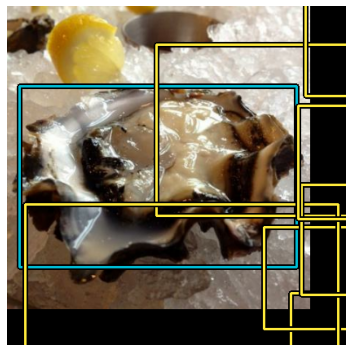

In [51]:
model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    from_logits=False,
    confidence_threshold=0.99,
    iou_threshold=0.2,
    bounding_box_format="xyxy",
)
for result in test_data.take(1):
    y_pred = model.predict(result[0])
    print(y_pred)
    visualization.plot_bounding_box_gallery(
        result[0],
        value_range=(0, 255),
        rows=1,
        cols=1,
        scale=5,
        bounding_box_format='xyxy',
        y_pred=y_pred,
        y_true=result[1]
    )

In [74]:
model.export("/mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model")

INFO:tensorflow:Assets written to: /mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model/assets


INFO:tensorflow:Assets written to: /mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model/assets


Saved artifact at '/mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='keras_tensor_244')
Output Type:
  Dict[['boxes', TensorSpec(shape=(None, None, 64), dtype=tf.float32, name=None)], ['classes', TensorSpec(shape=(None, None, 38), dtype=tf.float32, name=None)]]
Captures:
  139691732191008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139691732190656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139691732195584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139691732192592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139691732193472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139691732199632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139691732189600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139691732203680: TensorSpec(shape=(), dtype=tf.r

In [73]:
loaded_model = tf.keras.models.load_model("/mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/model.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
{'boxes': array([[[ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        ...,
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ]],

       [[ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        ...,
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ]],

       [[ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        ...,
        [ -1.     ,  -1.     ,  -1.     ,  -1.     ],
        [ -1.     ,  -1.     ,  -1.     ,  -1. 

2024-06-09 06:35:09.562769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


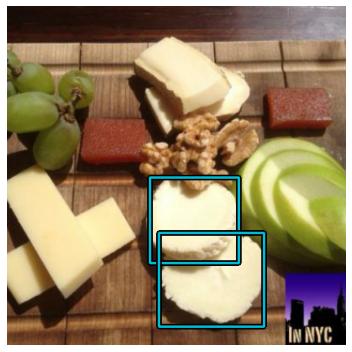

In [64]:
loaded_model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    from_logits=False,
    confidence_threshold=0.97,
    iou_threshold=0.2,
    bounding_box_format="xyxy",
)
for result in test_data.take(1):
    y_pred = loaded_model.predict(result[0])
    print(y_pred)
    visualization.plot_bounding_box_gallery(
        result[0],
        value_range=(0, 255),
        rows=1,
        cols=1,
        scale=5,
        bounding_box_format='xyxy',
        y_pred=y_pred,
        y_true=result[1]
    )

In [52]:
print(model.outputs)

[<KerasTensor shape=(None, None, 64), dtype=float32, sparse=False, name=keras_tensor_431>, <KerasTensor shape=(None, None, 38), dtype=float32, sparse=False, name=keras_tensor_432>]
